# Проект "Промышленность: построение модели предсказания температуры стали"

# Задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Описание установки "ковш-печь"

Агрегат ковш-печь или установка ковш-печь, также называется агрегатом комплексной обработки стали (АКОС) — это звено в единой технологической схеме с дуговыми печами, конвертерами и мартенами для доведения металла в ковше, после его выпуска из плавильного агрегата, до заданной температуры и химического состава.

Один цикл плавки состоит из разогрева, добавления сыпучих материалов и проволочных с последующим перемешиванием инертным газом.

[![155.jpg](https://i.postimg.cc/jdtWQkLX/155.jpg)](https://postimg.cc/9zgFcbPR)

<font color='green'>
    
### Примерный план выполнения проекта

* Изучить процесс обработки стали в металлическом ковше
* Провести исследование данных
* Провести предобработку данных
* Сформирования признаки обучения и целевой признак (температуры стали)
* Собрать все данные в одну таблицу
* Разделить полученный датасет на обучающую и тестовую выборки c соотношением 1:3 (RANDOM_STATE = 190922)
* Обучить разные модели с задачей регрессии и кросс валидацией (маловато строк в данных) по обучающей выборке 
* Выбрать лучшую модель и провести финальное тестирование на тестовой выборке
* Сделать выводы по проекту  

## Исследование данных

### Импорт библиотек

In [1]:
#pip install catboost
#pip install lightgbm

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import timeit

from datetime import datetime, date, time

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import (
    make_scorer, 
    mean_absolute_error
)  
from sklearn.model_selection import (
    cross_val_score, 
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

RANDOM_STATE = 190922

### Загрузка данных

In [3]:
try:
    data_arc = pd.read_csv('C:\\Users\\Имя\\Desktop\ML\\final_steel\\final_steel\\data_arc.csv')
    data_bulk = pd.read_csv('C:\\Users\\Имя\\Desktop\ML\\final_steel\\final_steel\\data_bulk.csv')
    data_bulk_time = pd.read_csv('C:\\Users\\Имя\\Desktop\ML\\final_steel\\final_steel\\data_bulk_time.csv')
    data_gas = pd.read_csv('C:\\Users\\Имя\\Desktop\ML\\final_steel\\final_steel\\data_gas.csv')
    data_temp = pd.read_csv('C:\\Users\\Имя\\Desktop\ML\\final_steel\\final_steel\\data_temp.csv')
    data_wire = pd.read_csv('C:\\Users\\Имя\\Desktop\ML\\final_steel\\final_steel\\data_wire.csv')
    data_wire_time = pd.read_csv('C:\\Users\\Имя\\Desktop\ML\\final_steel\\final_steel\\data_wire_time.csv')
except FileNotFoundError:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### Анализ данных

#### Напишем функцию для получения общей информации о датафрейме и функцию построения гистограммы с графиком «ящик с усами» + describe для столбца и функцию гистограммы для временных столбцов 

In [4]:
def gen_info(df):
    display(df.head(5)) 
    display(df.tail(5))
    print()
    print(df.describe())
    print()
    df.info()
    print()
    print('Количество строк:', df.shape[0])
    print()
    print('Общее количество ячеек с пропусками в df:', df.isna().sum().sum())
    print()
    print('Количество дубликатов строк:', df.duplicated().sum(), ', это:'
      , df.duplicated().sum() * 100 / df.shape[0], '% от всего датафрейма')
    
    
def form_fun(df, col, bins, rang=None):
    print('                               ____________ Столбец:', col, '___________' )
    print()
    t = 'Гистограмма столбца ' + col
    b = 'boxplot столбца ' + col
    fig, axes = plt.subplots(1,2,figsize=(17,5))

    df[col].hist(bins=bins, ax=axes[0], range=rang)
    sns.boxplot(x=df[col], ax=axes[1])  

    axes[0].set_title(t)
    axes[1].set_title(b)

    print(df[col].describe())

    plt.show()
    print()

    
def just_hist(df, col, bins, rang=None):
    print('                               ____________ Столбец:', col, '___________' )
    print()
    t = 'Гистограмма столбца ' + col

    ax = df[col].hist(bins=bins, figsize=(16, 5))
    ax.set_title(t)

    plt.show()
    
    print('Минимальное значение даты: ', df[col].min())
    print('Максимальное значение даты: ', df[col].max())
    print()
    print()

#### Напишем функцию для автоматического анализа типа данных столбцов и правильному обращению к функиям построения гистограмм и boxplot (form_fun или just_hist)

In [5]:
def visual(df):
    columns = df.columns.values
    inf = df.dtypes.values.tolist()
    i = -1
    for col in columns:
        i += 1
        if inf[i] in ['float64', 'int64']:
            form_fun(df, col, 60)
        elif inf[i] == '<M8[ns]':
            just_hist(df, col, 200) 

#### Напишем функцию для изменения типа данных в столбцах с object на datetime

In [6]:
def to_time(df):
    columns = df.columns.values
    inf = df.dtypes.values.tolist()
    i = -1
    for col in columns:
        i += 1
        if inf[i] == 'O':
            df[col] = pd.to_datetime(df[col], format = '%Y-%m-%dT%H:%M:%S')       
    return df

#### Таблица data_arc — "Данные об электродах"

##### Общая информация

In [7]:
gen_info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708



                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034             0.637371
max     3241.000000           3.731596             2.676388

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  f

##### Приведем столбцы 'Начало нагрева дугой' и 'Конец нагрева дугой' к типу datetime

In [8]:
data_arc = to_time(data_arc)

##### Распределение

                               ____________ Столбец: key ___________

count    14876.000000
mean      1615.220422
std        934.571502
min          1.000000
25%        806.000000
50%       1617.000000
75%       2429.000000
max       3241.000000
Name: key, dtype: float64


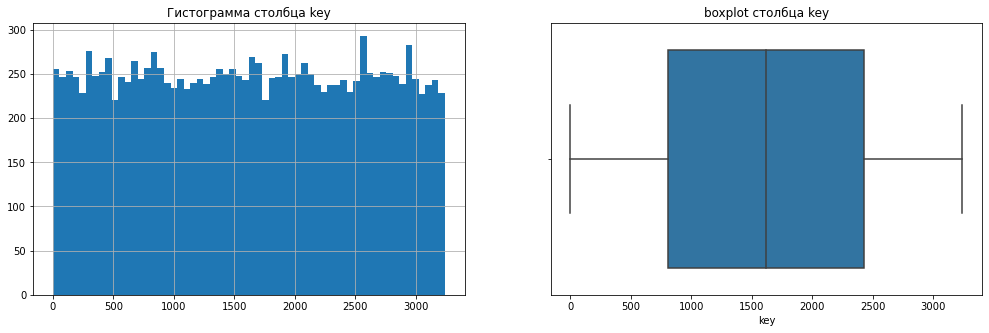


                               ____________ Столбец: Начало нагрева дугой ___________



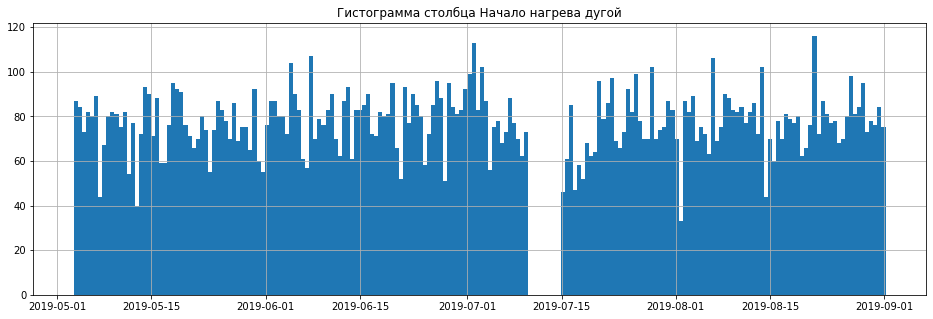

Минимальное значение даты:  2019-05-03 11:02:14
Максимальное значение даты:  2019-09-01 04:34:47


                               ____________ Столбец: Конец нагрева дугой ___________



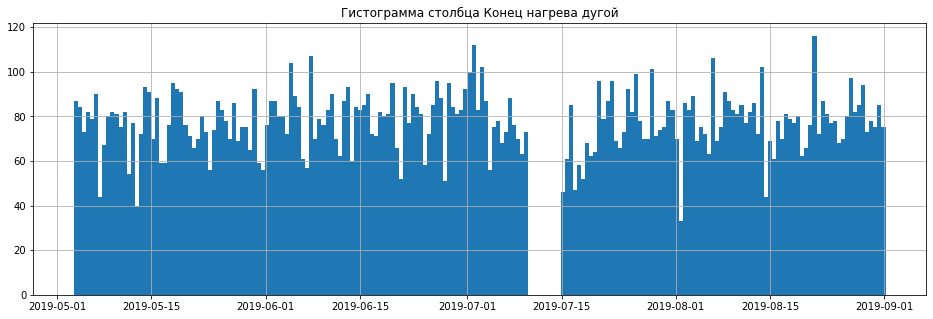

Минимальное значение даты:  2019-05-03 11:06:02
Максимальное значение даты:  2019-09-01 04:36:08


                               ____________ Столбец: Активная мощность ___________

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: Активная мощность, dtype: float64


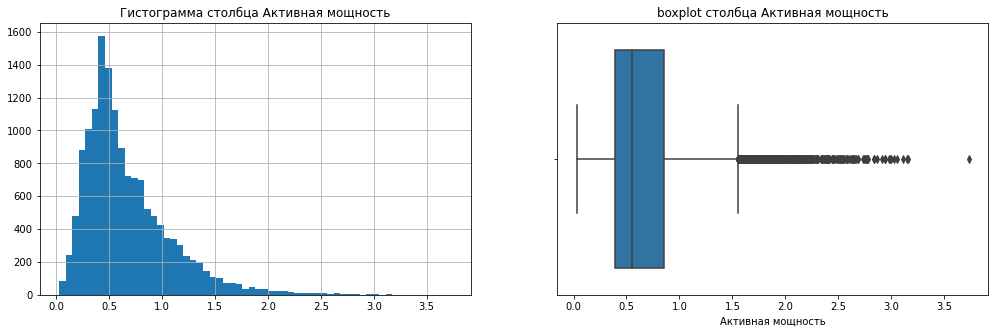


                               ____________ Столбец: Реактивная мощность ___________

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: Реактивная мощность, dtype: float64


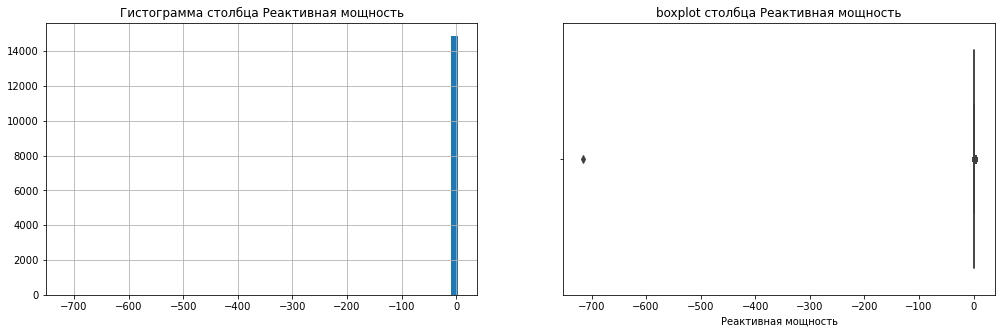

In [9]:
visual(data_arc)

##### Проверим распределение на нормальность в столбце Активная мощность с помощью статистических тестов Шапиро-Уилк  и Критерий согласия Пирсона

In [10]:
stat, p = scipy.stats.shapiro(data_arc['Активная мощность']) # тест Шапиро-Уилк 
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.886, p-value=0.000
Отклонить гипотезу о нормальности


In [11]:
stat, p = scipy.stats.normaltest(data_arc['Активная мощность']) # Критерий согласия Пирсона
print('Statistics=%.3f, p-value=%.3f' % (stat, p)) 
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=4438.015, p-value=0.000
Отклонить гипотезу о нормальности


##### **Вывод:**
* Общее количество строк: 14876
* Нет пропусков и дубликатов
* Столбец key представлен в виде числового ряда из натуральных, повторяющихся, в среднем по 5 чисел.
* Столбец Начало нагрева дугой визуально имеет равномерное распределение в течении всего временного ряда, за исключением отсутствующих значений на протяжении нескольких дней
* Столбец Конец нагрева дугой визуально имеет равномерное распределение в течении всего временного ряда, за исключением отсутствующих значений на протяжении нескольких дней и в целом повторяет очертания предыдущего столбца
* Столбец Активная мощность не имеет нормальное распределение, а скорее внешне напонминает логнормальное с выбросами в большую сторону
* Столбец Реактивная мощность требует удаления явных аномалий (например -715), после чего можно предположить что распределение будет похоже на распределение в столбце Активная мощность.
* Степень аномалий можно будет оценить в предобработке, для которой необходимо создание дополнительных столбцов: полная мощность, cos φ

#### Таблица data_bulk — "Данные о подаче сыпучих материалов (объём)"

##### Общая информация

In [12]:
gen_info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0



               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000 

##### Распределение

                               ____________ Столбец: key ___________

count    3129.000000
mean     1624.383509
std       933.337642
min         1.000000
25%       816.000000
50%      1622.000000
75%      2431.000000
max      3241.000000
Name: key, dtype: float64


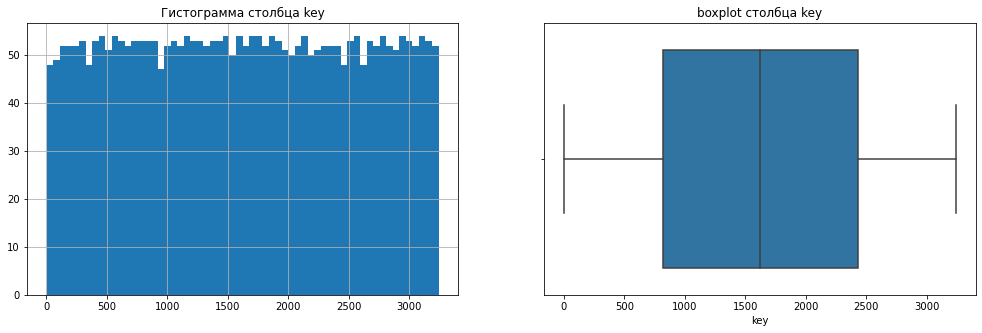


                               ____________ Столбец: Bulk 1 ___________

count    252.000000
mean      39.242063
std       18.277654
min       10.000000
25%       27.000000
50%       31.000000
75%       46.000000
max      185.000000
Name: Bulk 1, dtype: float64


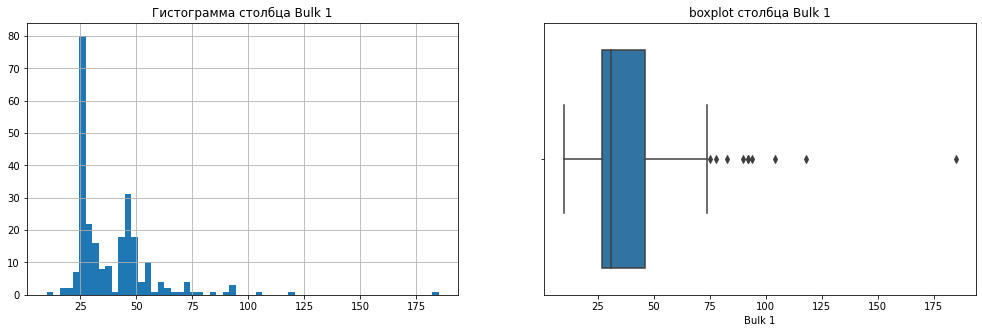


                               ____________ Столбец: Bulk 2 ___________

count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: Bulk 2, dtype: float64


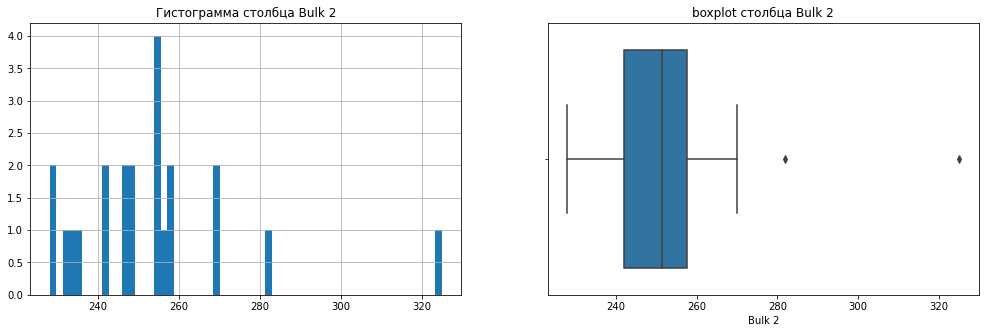


                               ____________ Столбец: Bulk 3 ___________

count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64


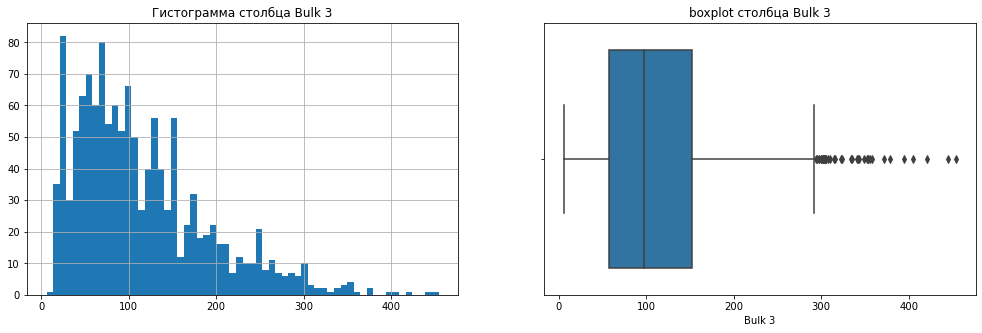


                               ____________ Столбец: Bulk 4 ___________

count    1014.000000
mean      104.394477
std        48.184126
min        12.000000
25%        72.000000
50%       102.000000
75%       133.000000
max       281.000000
Name: Bulk 4, dtype: float64


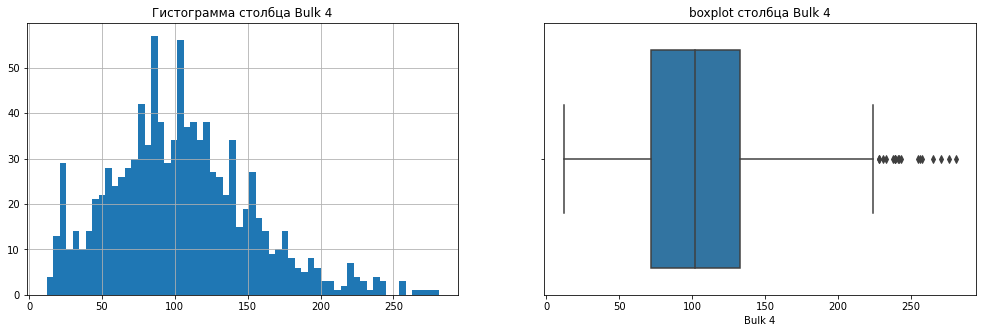


                               ____________ Столбец: Bulk 5 ___________

count     77.000000
mean     107.025974
std       81.790646
min       11.000000
25%       70.000000
50%       86.000000
75%      132.000000
max      603.000000
Name: Bulk 5, dtype: float64


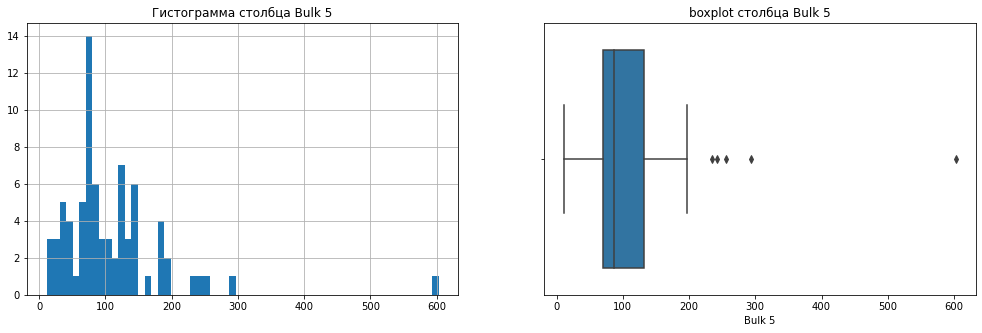


                               ____________ Столбец: Bulk 6 ___________

count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: Bulk 6, dtype: float64


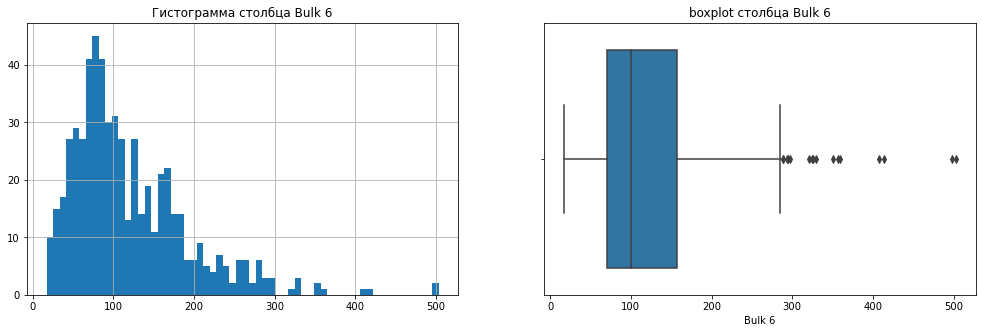


                               ____________ Столбец: Bulk 7 ___________

count     25.000000
mean     305.600000
std      191.022904
min       47.000000
25%      155.000000
50%      298.000000
75%      406.000000
max      772.000000
Name: Bulk 7, dtype: float64


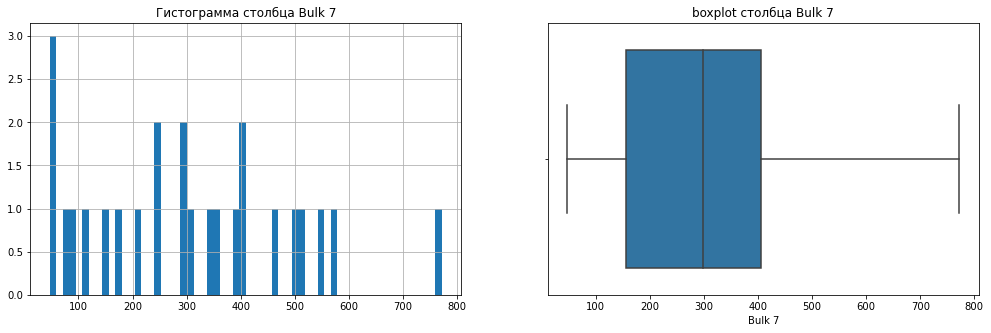


                               ____________ Столбец: Bulk 8 ___________

count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: Bulk 8, dtype: float64


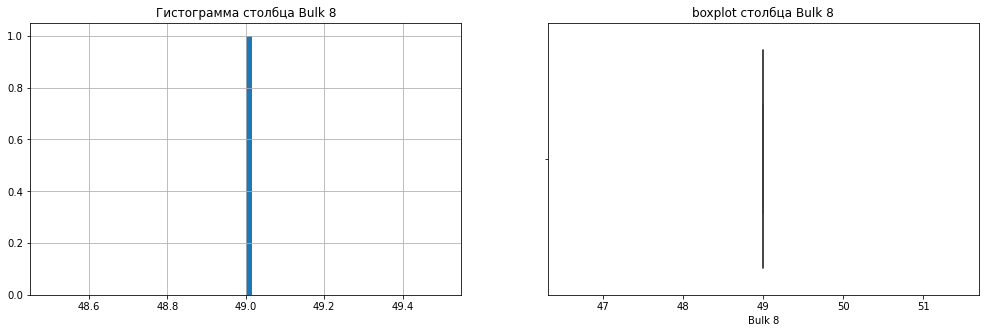


                               ____________ Столбец: Bulk 9 ___________

count     19.000000
mean      76.315789
std       21.720581
min       63.000000
25%       66.000000
50%       68.000000
75%       70.500000
max      147.000000
Name: Bulk 9, dtype: float64


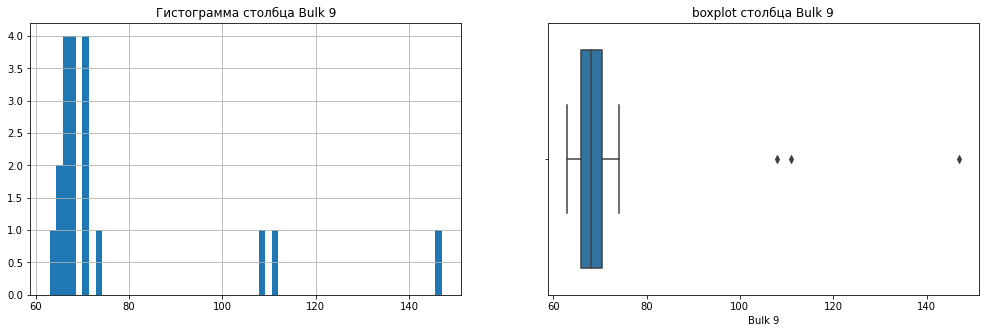


                               ____________ Столбец: Bulk 10 ___________

count    176.000000
mean      83.284091
std       26.060347
min       24.000000
25%       64.000000
50%       86.500000
75%      102.000000
max      159.000000
Name: Bulk 10, dtype: float64


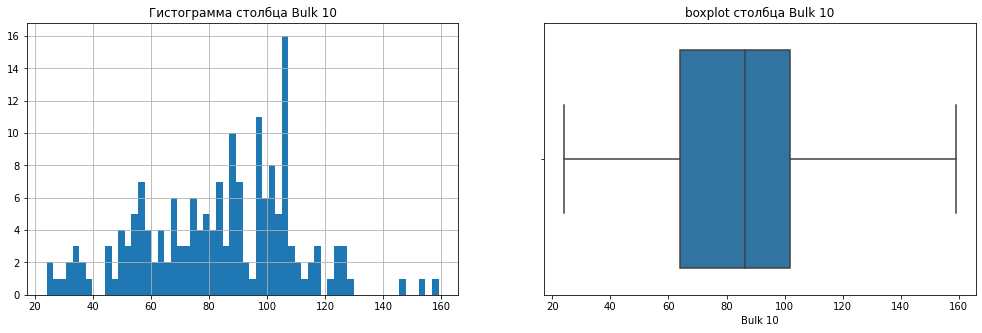


                               ____________ Столбец: Bulk 11 ___________

count    177.000000
mean      76.819209
std       59.655365
min        8.000000
25%       25.000000
50%       64.000000
75%      106.000000
max      313.000000
Name: Bulk 11, dtype: float64


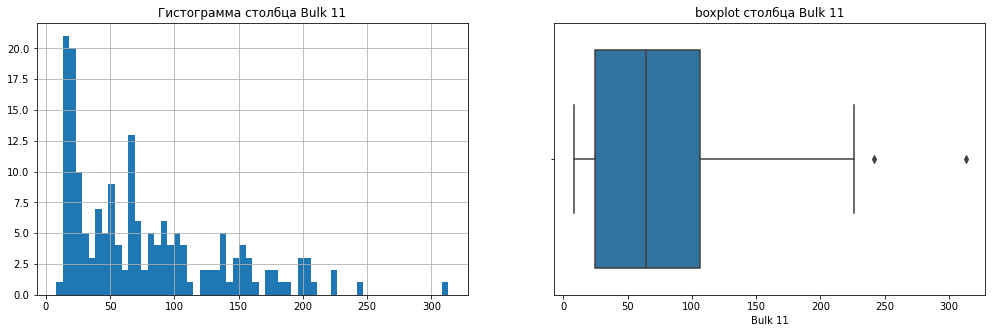


                               ____________ Столбец: Bulk 12 ___________

count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: Bulk 12, dtype: float64


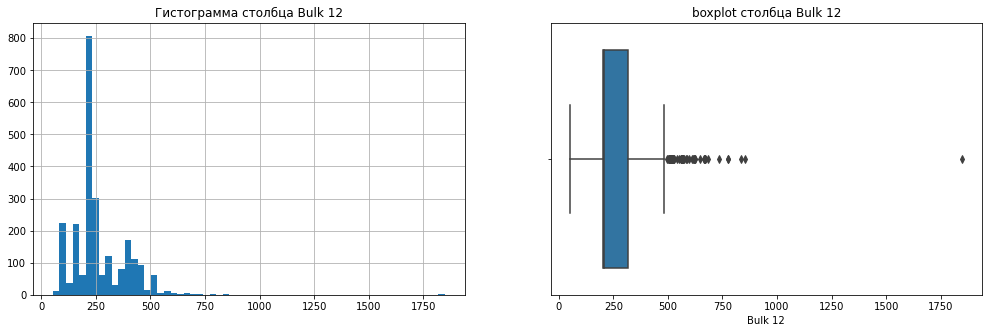


                               ____________ Столбец: Bulk 13 ___________

count     18.000000
mean     181.111111
std       46.088009
min      151.000000
25%      153.250000
50%      155.500000
75%      203.500000
max      305.000000
Name: Bulk 13, dtype: float64


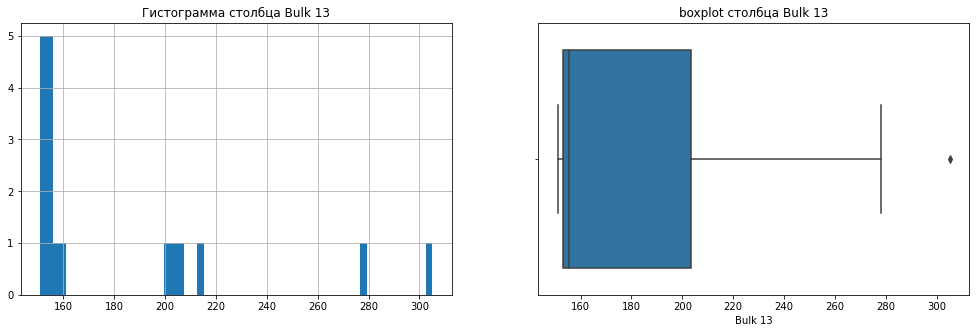


                               ____________ Столбец: Bulk 14 ___________

count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: Bulk 14, dtype: float64


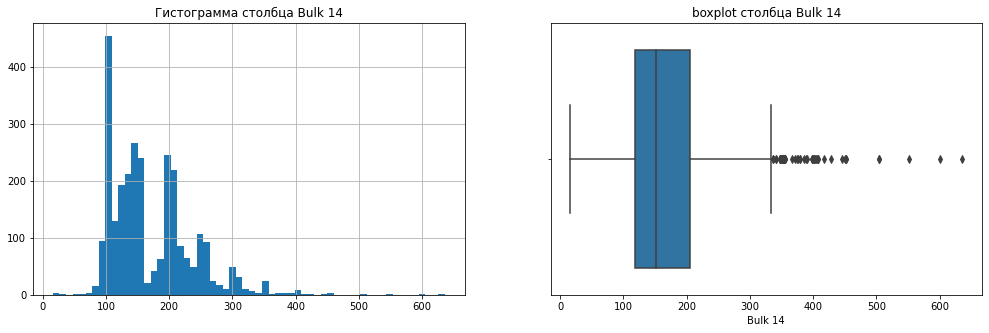


                               ____________ Столбец: Bulk 15 ___________

count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: Bulk 15, dtype: float64


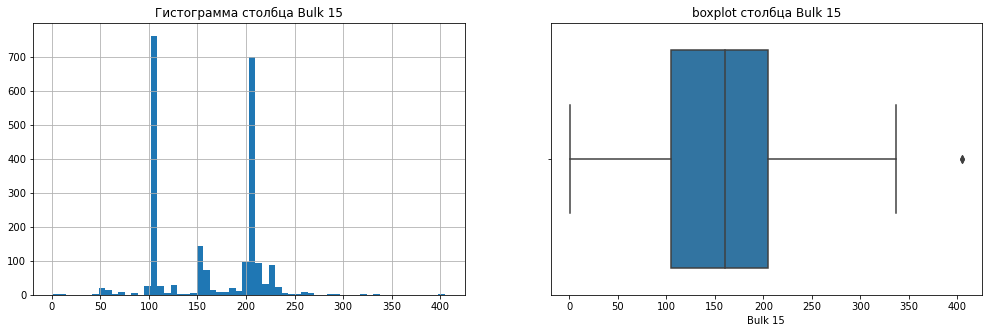

In [13]:
visual(data_bulk)

##### **Вывод:**
* Общее количество строк: 3129
* 35776 ячеек с пропусками (в предобработке будет замена на нули)
* Нет дубликатов
* Столбцы представляют собой конкретный сыпучий материал, который добавляется в расплав в зависимости от входных химических характеристик сплава, а также спецификации к требуемой марки стали, поэтому некоторые столбцы (материалы) "используются" часто, а некоторые редко или всего один раз.
* Материалы, используемые часто в столбцах Bulk 3, Bulk 4, Bulk 6, Bulk 12 и Bulk 14 визуально имеют асимметричное распределение.
* В столбцах присутствуют единичные выбросы, возможно это реальные значения, но при обучении могут снизить качество модели и вероятно придется от них избавиться. (можно попробовать так и так)

#### Таблица data_bulk_time — "Данные о подаче сыпучих материалов (время)"

##### Общая информация

In [14]:
gen_info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34



               key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB



##### Приведем все столбцы, кроме ключа к типу datetime

In [15]:
data_bulk_time = to_time(data_bulk_time)

##### Распределение

                               ____________ Столбец: key ___________

count    3129.000000
mean     1624.383509
std       933.337642
min         1.000000
25%       816.000000
50%      1622.000000
75%      2431.000000
max      3241.000000
Name: key, dtype: float64


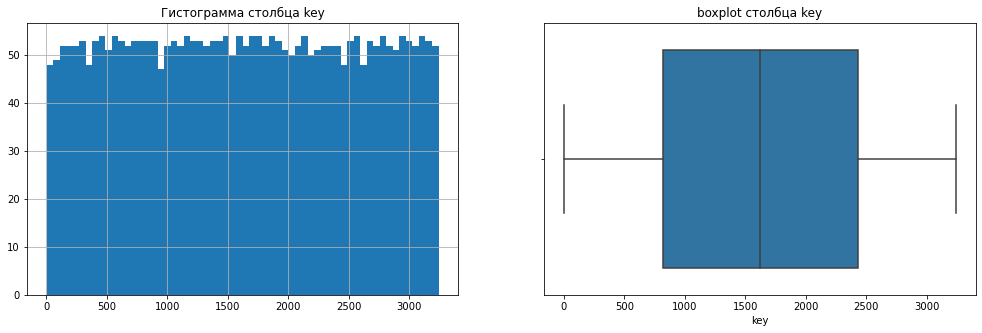


                               ____________ Столбец: Bulk 1 ___________



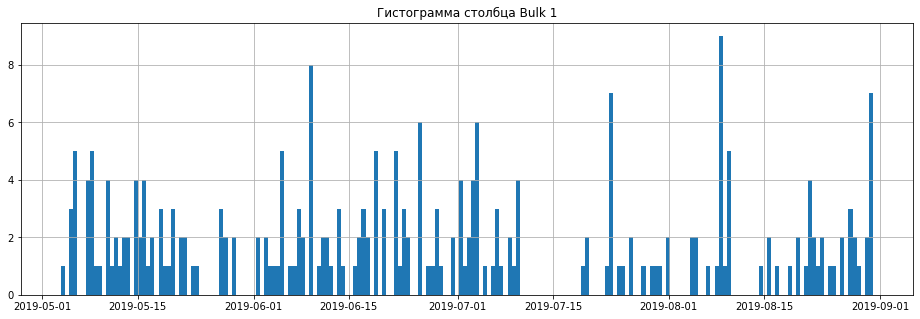

Минимальное значение даты:  2019-05-03 17:50:19
Максимальное значение даты:  2019-08-30 23:01:32


                               ____________ Столбец: Bulk 2 ___________



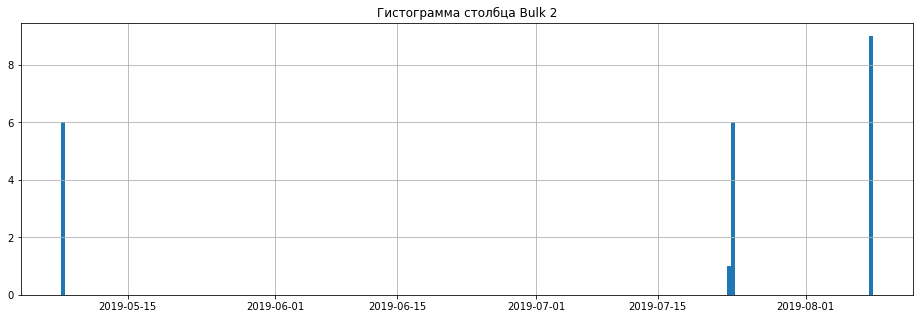

Минимальное значение даты:  2019-05-07 08:36:19
Максимальное значение даты:  2019-08-08 17:34:38


                               ____________ Столбец: Bulk 3 ___________



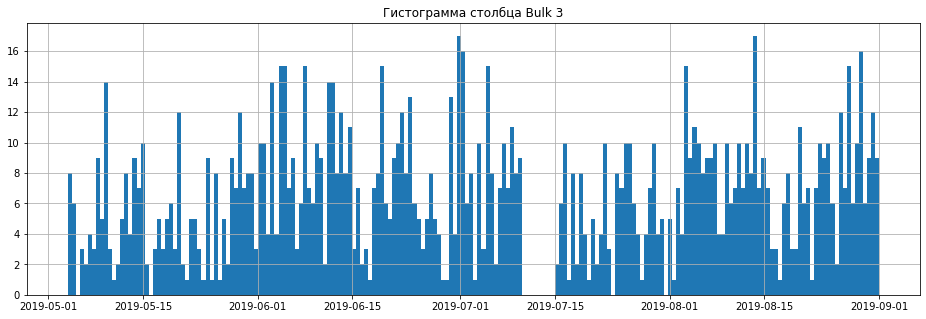

Минимальное значение даты:  2019-05-03 20:13:36
Максимальное значение даты:  2019-08-31 23:39:11


                               ____________ Столбец: Bulk 4 ___________



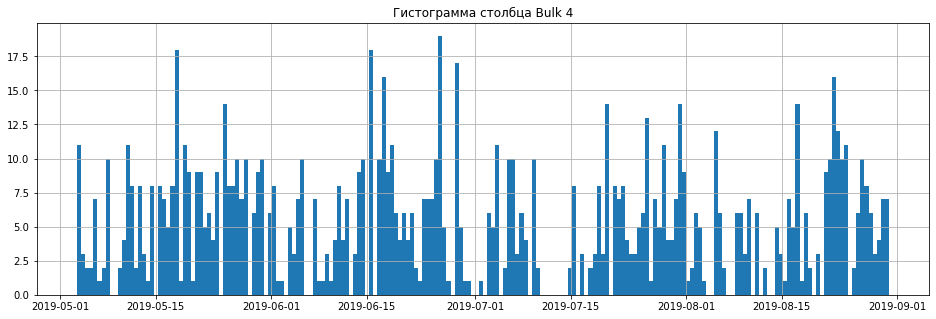

Минимальное значение даты:  2019-05-03 11:21:30
Максимальное значение даты:  2019-08-30 17:36:30


                               ____________ Столбец: Bulk 5 ___________



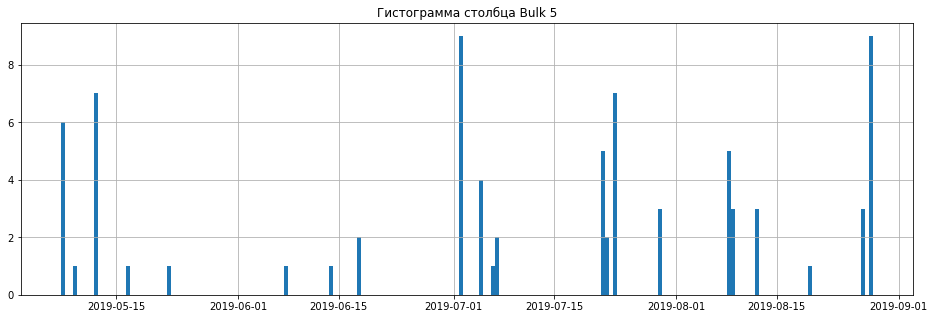

Минимальное значение даты:  2019-05-07 08:36:19
Максимальное значение даты:  2019-08-28 09:01:08


                               ____________ Столбец: Bulk 6 ___________



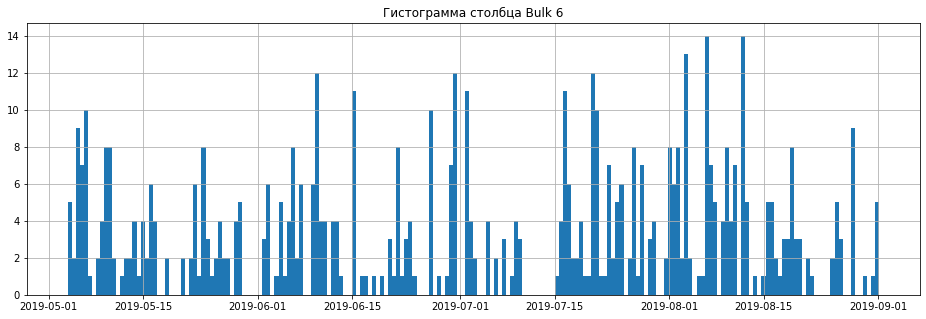

Минимальное значение даты:  2019-05-03 18:52:57
Максимальное значение даты:  2019-09-01 03:12:40


                               ____________ Столбец: Bulk 7 ___________



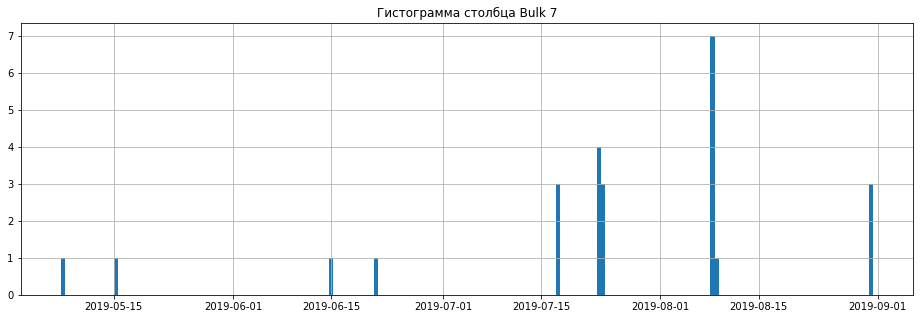

Минимальное значение даты:  2019-05-07 11:37:42
Максимальное значение даты:  2019-08-31 07:22:25


                               ____________ Столбец: Bulk 8 ___________



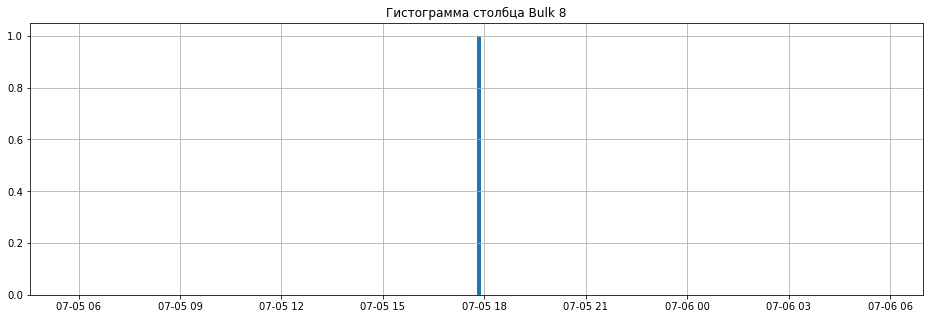

Минимальное значение даты:  2019-07-05 17:46:11
Максимальное значение даты:  2019-07-05 17:46:11


                               ____________ Столбец: Bulk 9 ___________



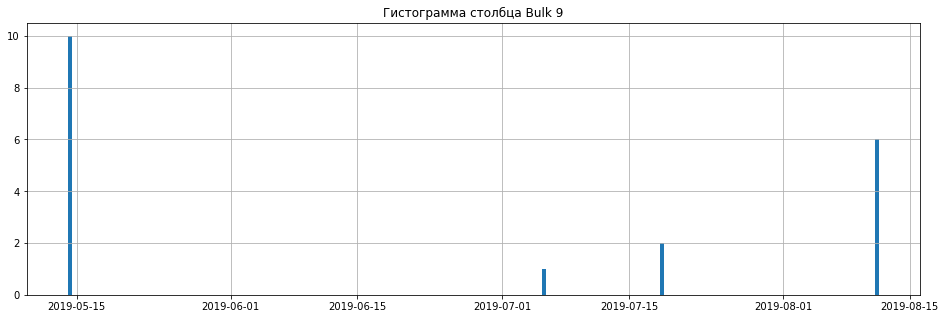

Минимальное значение даты:  2019-05-14 00:04:56
Максимальное значение даты:  2019-08-11 15:09:33


                               ____________ Столбец: Bulk 10 ___________



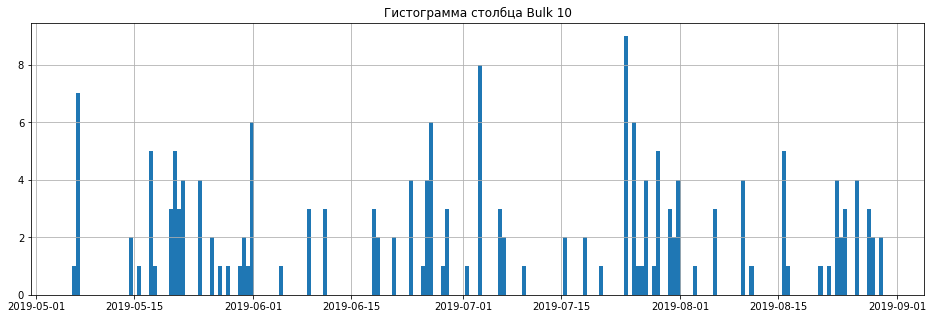

Минимальное значение даты:  2019-05-06 01:36:24
Максимальное значение даты:  2019-08-30 01:30:42


                               ____________ Столбец: Bulk 11 ___________



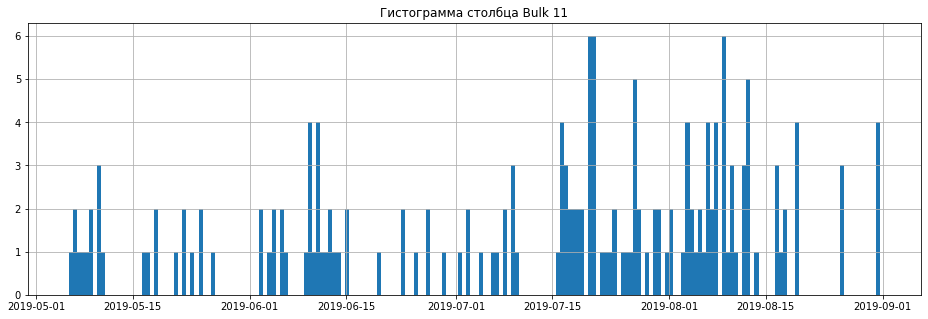

Минимальное значение даты:  2019-05-05 16:45:05
Максимальное значение даты:  2019-08-31 16:00:49


                               ____________ Столбец: Bulk 12 ___________



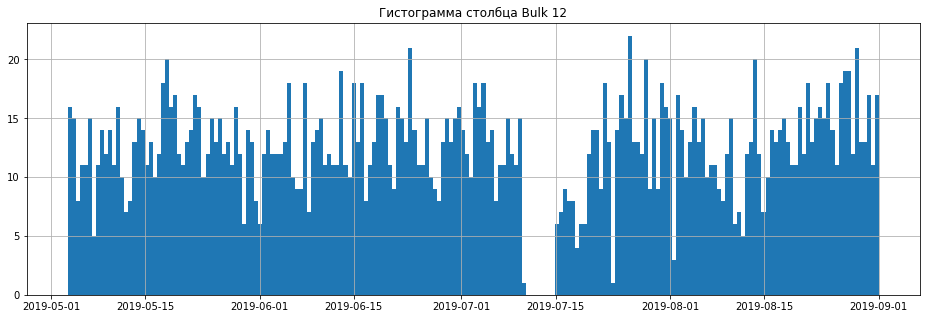

Минимальное значение даты:  2019-05-03 11:03:52
Максимальное значение даты:  2019-09-01 01:39:41


                               ____________ Столбец: Bulk 13 ___________



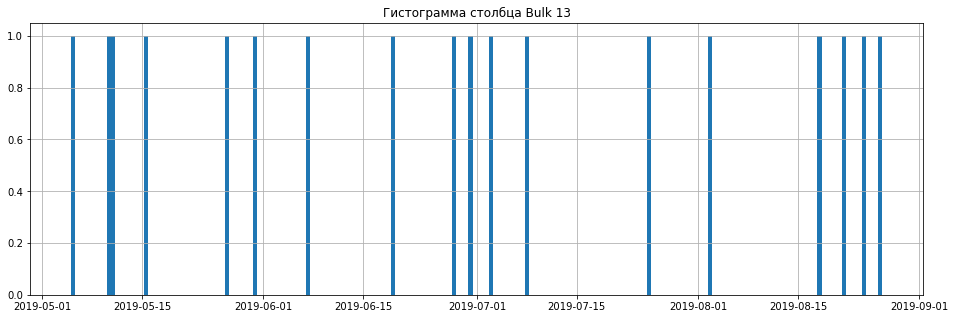

Минимальное значение даты:  2019-05-05 00:39:35
Максимальное значение даты:  2019-08-26 20:31:16


                               ____________ Столбец: Bulk 14 ___________



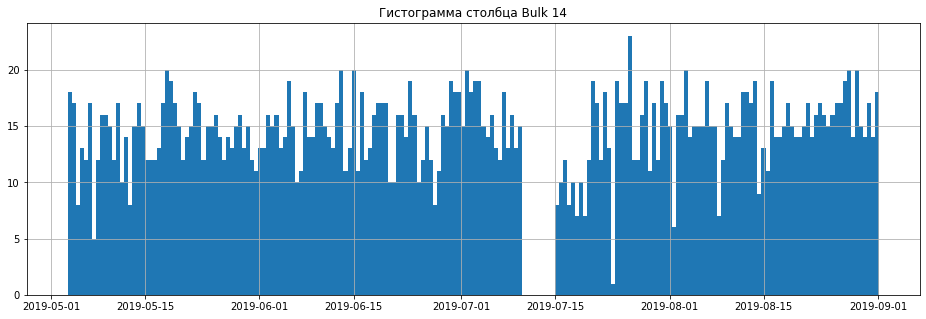

Минимальное значение даты:  2019-05-03 11:03:52
Максимальное значение даты:  2019-09-01 04:05:34


                               ____________ Столбец: Bulk 15 ___________



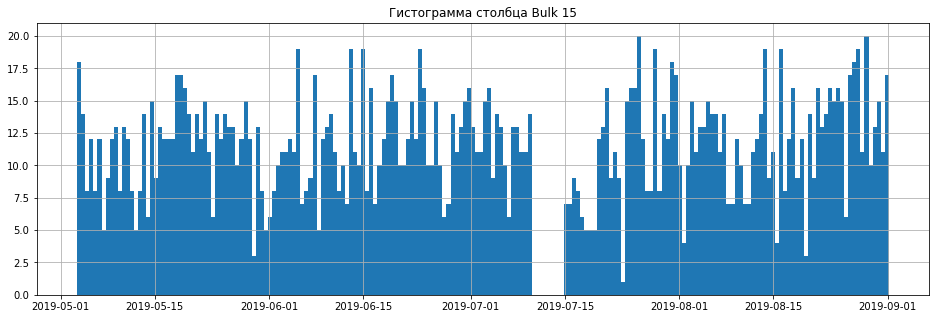

Минимальное значение даты:  2019-05-03 11:03:52
Максимальное значение даты:  2019-09-01 04:05:34




In [16]:
visual(data_bulk_time)

##### **Вывод:**
* Общее количество строк: 3129
* 35776 ячеек с пропусками (пропуски соответствуют отсутствию добавления сыпучих материалов)
* Нет дубликатов
* таблица повторяет структуру data_bulk 
* Столбцы представляют собой время для конкретного сыпучего материала, который добавляется в расплав в зависимости от входных химических характеристик сплава (нет добавления сыпучего материала — нет времени).
* Наличии времён для выбросов из таблицы data_bulk говорит в пользу того что значения реальны и не являются аномалиями.
* Наблюдается временной "провал" по всем столбцам похожий на "провал" в таблице data_arc

#### Таблица data_gas — "Данные о продувке сплава газом"

##### Общая информация

In [17]:
gen_info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959



               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Количество строк: 3239

Общее количество ячеек с пропусками в df: 0

Количество дубликатов строк: 0 , это: 0.0 % от всего датафрейма


##### Распределение

                               ____________ Столбец: key ___________

count    3239.000000
mean     1621.861377
std       935.386334
min         1.000000
25%       812.500000
50%      1622.000000
75%      2431.500000
max      3241.000000
Name: key, dtype: float64


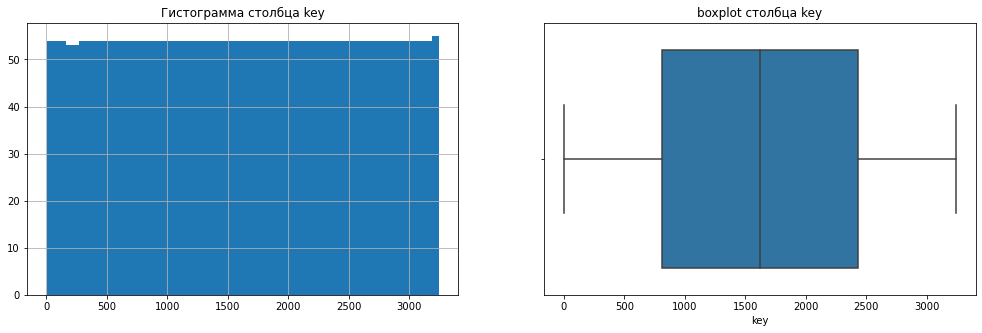


                               ____________ Столбец: Газ 1 ___________

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64


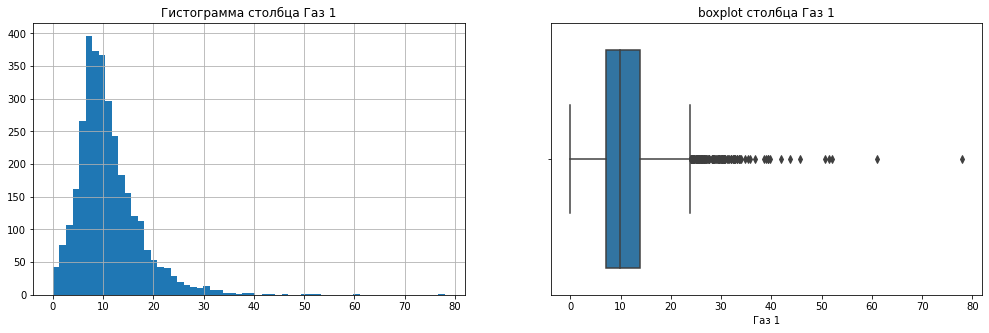

In [18]:
visual(data_gas)

##### **Вывод:**
* Общее количество строк: 3239
* Нет пропусков и дубликатов
* Имеются выбросы в большую сторону

#### Таблица data_temp — "Результаты измерения температуры"

##### Общая информация

In [19]:
gen_info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN



                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB

Количество строк: 15907

Общее количество ячеек с пропусками в df: 2901

Количество дубликатов строк: 0 , это: 0.0 % от всего датафрейма


##### Приведем столбец 'Время замера' к типу datetime

In [20]:
data_temp = to_time(data_temp)

##### Распределение

                               ____________ Столбец: key ___________

count    15907.000000
mean      1607.880870
std        942.212073
min          1.000000
25%        790.000000
50%       1618.000000
75%       2427.000000
max       3241.000000
Name: key, dtype: float64


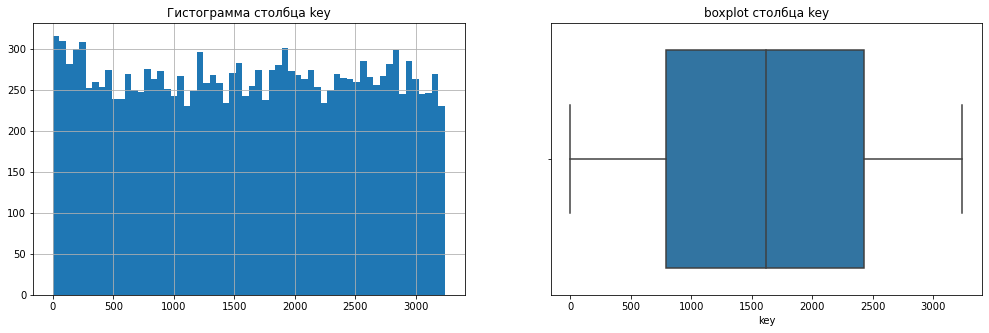


                               ____________ Столбец: Время замера ___________



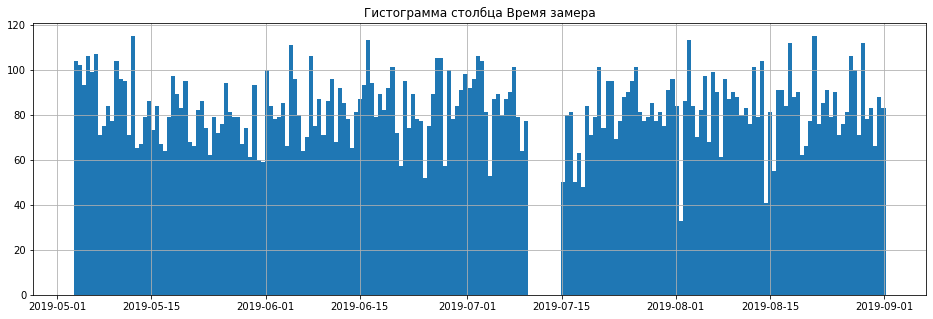

Минимальное значение даты:  2019-05-03 11:16:18
Максимальное значение даты:  2019-09-01 04:38:08


                               ____________ Столбец: Температура ___________

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64


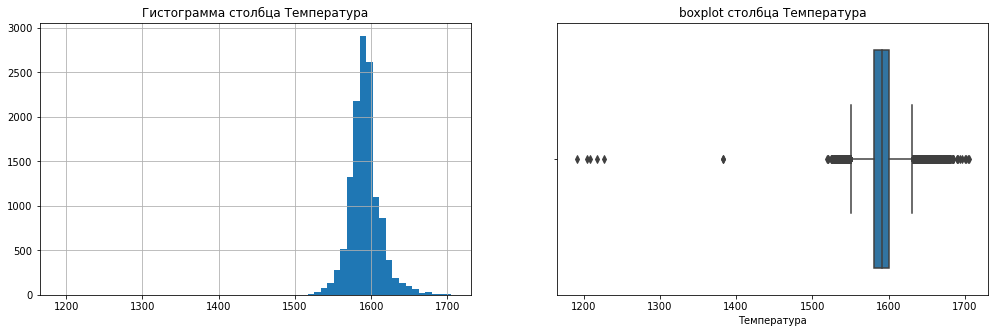

In [21]:
visual(data_temp)

##### **Вывод:**
* Общее количество строк: 15907
* 2901 ячеек с пропусками 
* Нет дубликатов
* Столбец имеет выбросы в большую сторону и сильно в меньшую сторону.

#### Таблица data_wire — "Данные о проволочных материалах (объём)"

##### Общая информация

In [22]:
gen_info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442842  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     

##### Распределение

                               ____________ Столбец: key ___________

count    3081.000000
mean     1623.426485
std       932.996726
min         1.000000
25%       823.000000
50%      1619.000000
75%      2434.000000
max      3241.000000
Name: key, dtype: float64


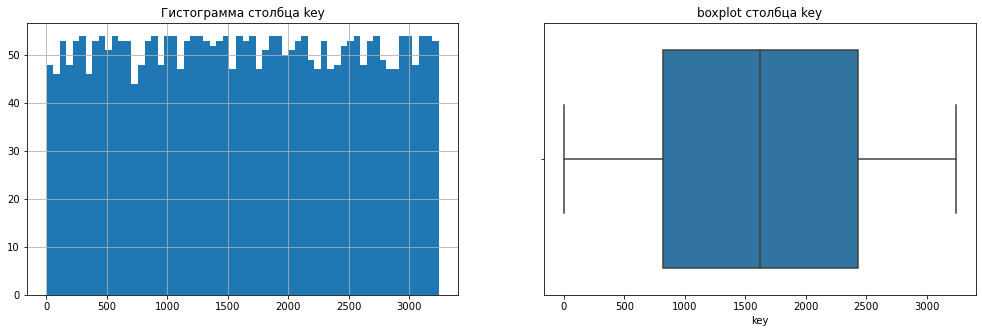


                               ____________ Столбец: Wire 1 ___________

count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060483
max       330.314424
Name: Wire 1, dtype: float64


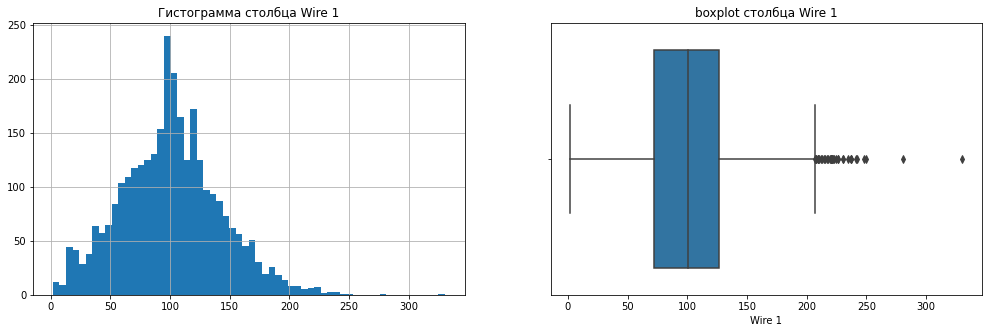


                               ____________ Столбец: Wire 2 ___________

count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64


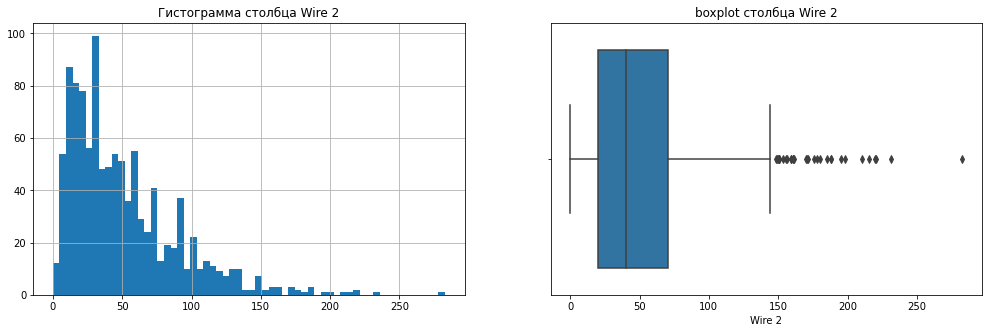


                               ____________ Столбец: Wire 3 ___________

count     63.000000
mean     189.482681
std       99.513444
min        0.144144
25%       95.135044
50%      235.194977
75%      276.252014
max      385.008668
Name: Wire 3, dtype: float64


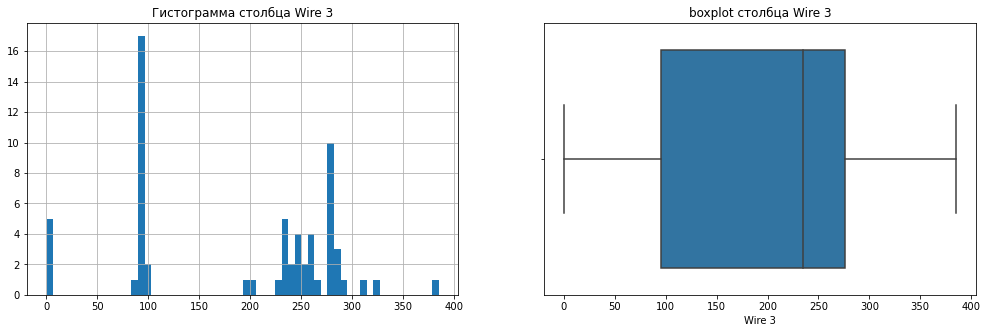


                               ____________ Столбец: Wire 4 ___________

count     14.000000
mean      57.442842
std       28.824667
min       24.148801
25%       40.807002
50%       45.234282
75%       76.124619
max      113.231044
Name: Wire 4, dtype: float64


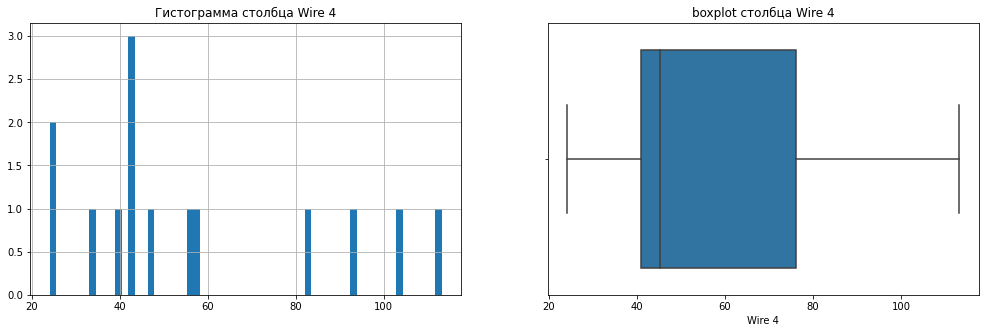


                               ____________ Столбец: Wire 5 ___________

count     1.000
mean     15.132
std         NaN
min      15.132
25%      15.132
50%      15.132
75%      15.132
max      15.132
Name: Wire 5, dtype: float64


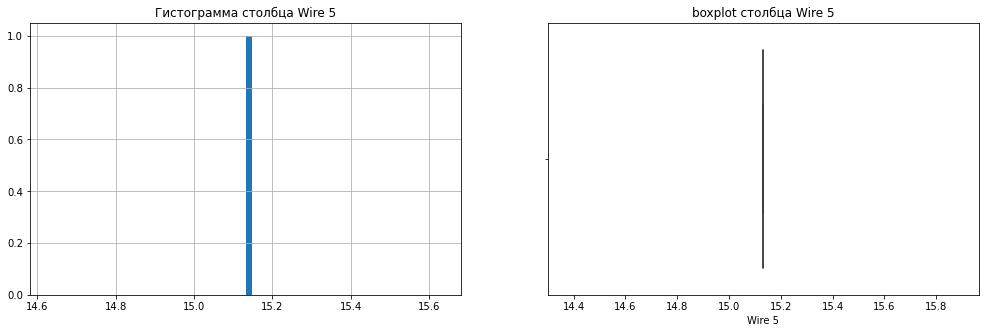


                               ____________ Столбец: Wire 6 ___________

count     73.000000
mean      48.016974
std       33.919845
min        0.034320
25%       25.053600
50%       42.076324
75%       64.212723
max      180.454575
Name: Wire 6, dtype: float64


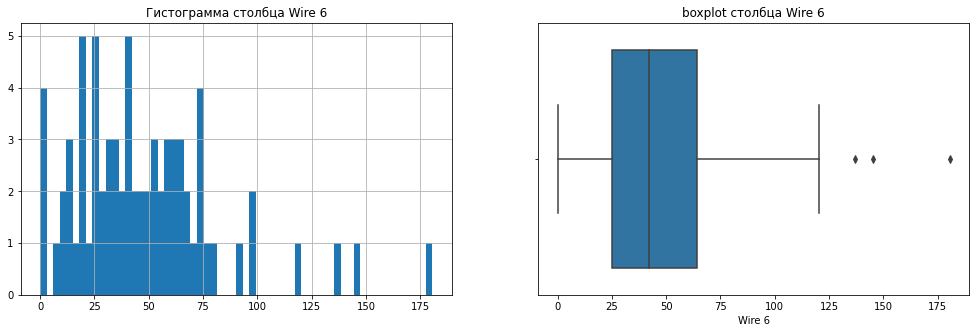


                               ____________ Столбец: Wire 7 ___________

count    11.000000
mean     10.039007
std       8.610584
min       0.234208
25%       6.762756
50%       9.017009
75%      11.886057
max      32.847674
Name: Wire 7, dtype: float64


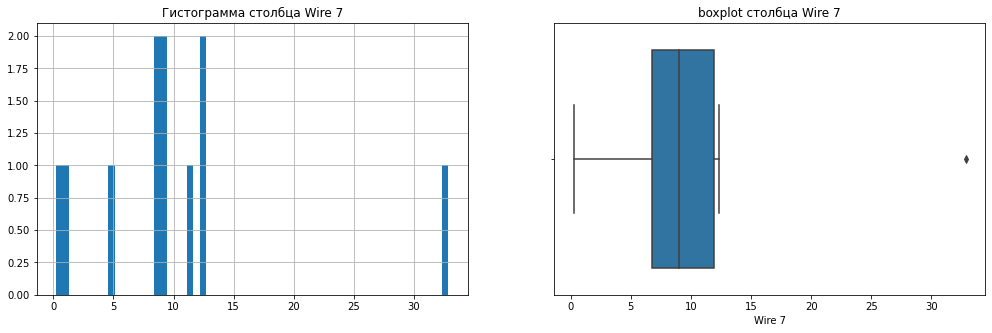


                               ____________ Столбец: Wire 8 ___________

count     19.000000
mean      53.625193
std       16.881728
min       45.076721
25%       46.094879
50%       46.279999
75%       48.089603
max      102.762401
Name: Wire 8, dtype: float64


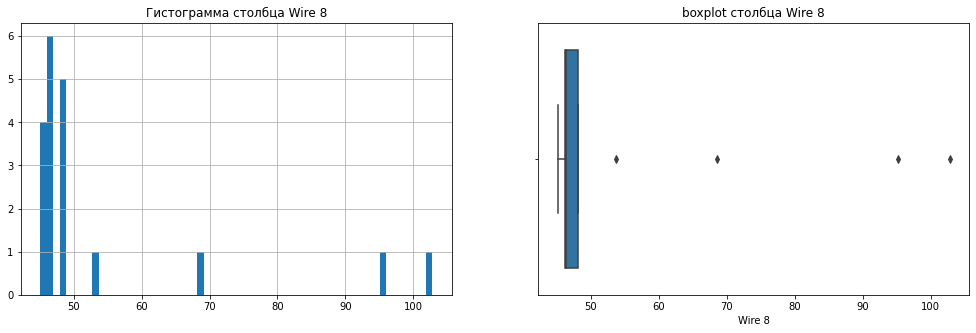


                               ____________ Столбец: Wire 9 ___________

count    29.000000
mean     34.155752
std      19.931616
min       4.622800
25%      22.058401
50%      30.066399
75%      43.862003
max      90.053604
Name: Wire 9, dtype: float64


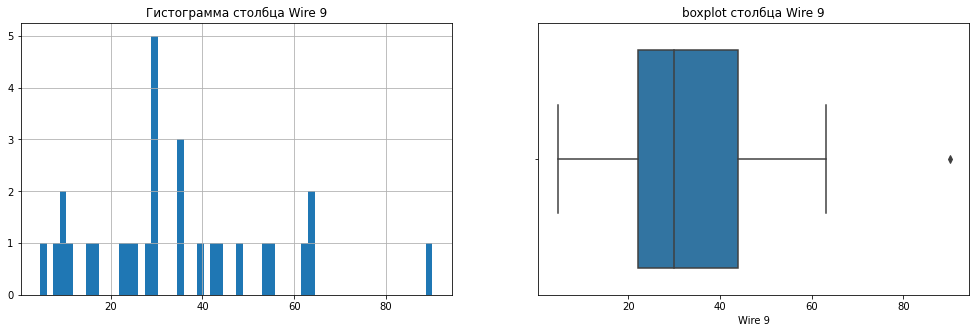

In [23]:
visual(data_wire)

##### **Вывод:**
* Общее количество строк: 3081
* 23385 ячеек с пропусками (в предобработке будет замена на нули)
* Нет дубликатов
* Столбцы представляют собой конкретный проволочный материал, который добавляется в расплав в зависимости от входных химических характеристик сплава, а также спецификации к требуемой марки стали, поэтому некоторые столбцы (материалы) "используются" часто, а некоторые редко или всего один раз.
* Материалы, используемые часто находятся в столбцах Wire 1 и Wire 2 
* В столбцах присутствуют единичные выбросы, скорее всего это реальные значения, но редко используемые в техпроцессе.

#### Таблица data_wire_time — "Данные о проволочных материалах (время)"

##### Общая информация

In [24]:
gen_info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Количество строк: 3081

Общее количество ячеек с пропусками в df: 23385

Количество дубликатов строк: 0 , это: 0.0 % от всего датафрейма


##### Приведем все столбцы, кроме ключа к типу datetime

In [25]:
data_wire_time = to_time(data_wire_time)

##### Распределение

                               ____________ Столбец: key ___________

count    3081.000000
mean     1623.426485
std       932.996726
min         1.000000
25%       823.000000
50%      1619.000000
75%      2434.000000
max      3241.000000
Name: key, dtype: float64


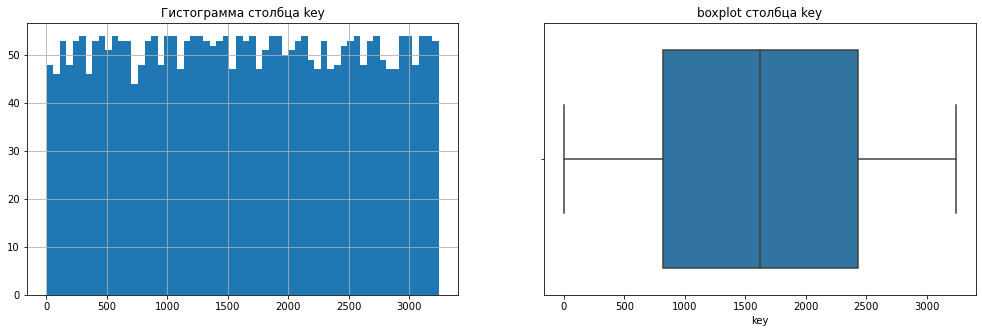


                               ____________ Столбец: Wire 1 ___________



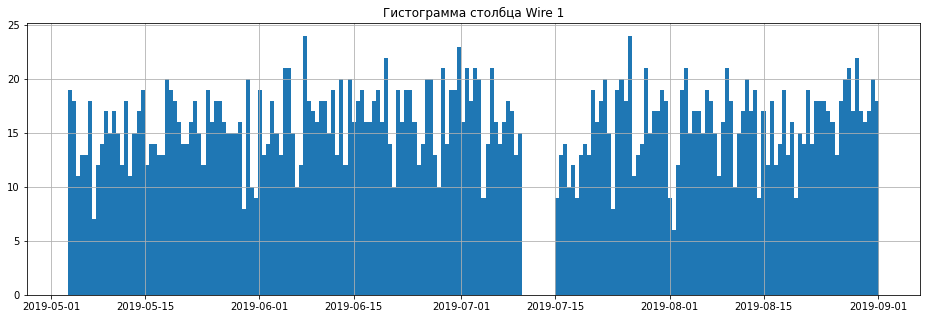

Минимальное значение даты:  2019-05-03 11:11:41
Максимальное значение даты:  2019-09-01 04:16:01


                               ____________ Столбец: Wire 2 ___________



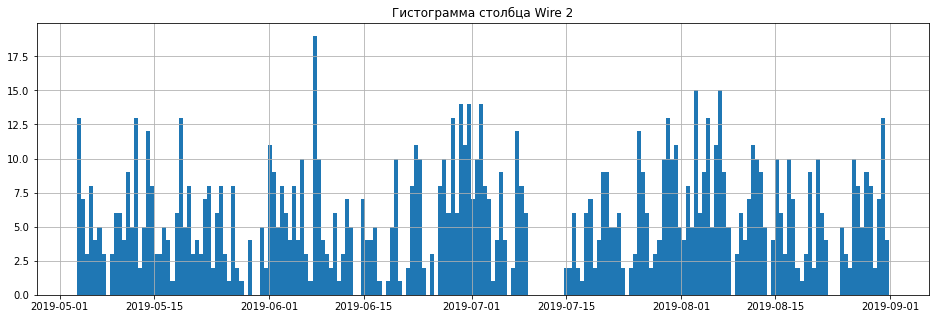

Минимальное значение даты:  2019-05-03 13:32:06
Максимальное значение даты:  2019-08-31 18:50:15


                               ____________ Столбец: Wire 3 ___________



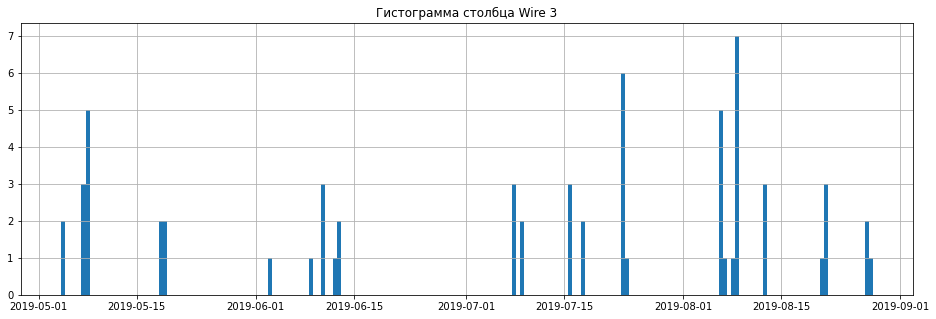

Минимальное значение даты:  2019-05-04 04:47:53
Максимальное значение даты:  2019-08-28 02:11:18


                               ____________ Столбец: Wire 4 ___________



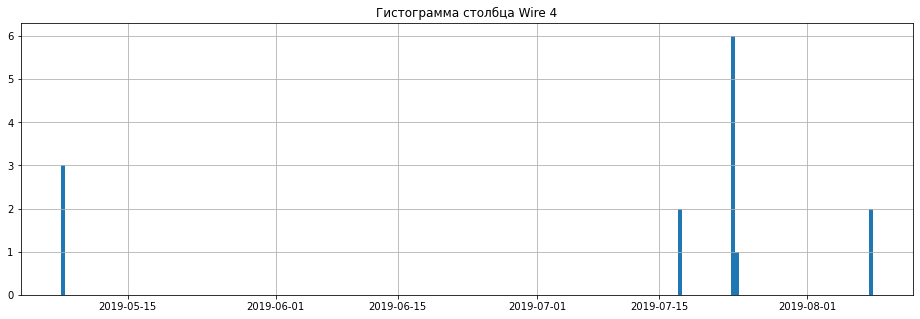

Минимальное значение даты:  2019-05-07 08:48:23
Максимальное значение даты:  2019-08-08 12:03:12


                               ____________ Столбец: Wire 5 ___________



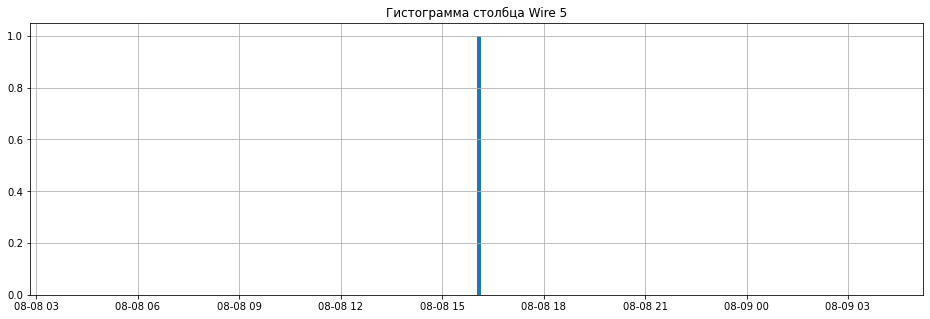

Минимальное значение даты:  2019-08-08 16:01:07
Максимальное значение даты:  2019-08-08 16:01:07


                               ____________ Столбец: Wire 6 ___________



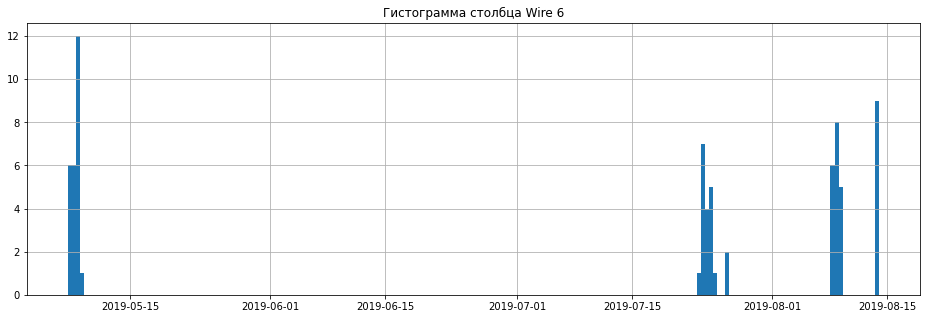

Минимальное значение даты:  2019-05-07 08:37:20
Максимальное значение даты:  2019-08-14 00:59:11


                               ____________ Столбец: Wire 7 ___________



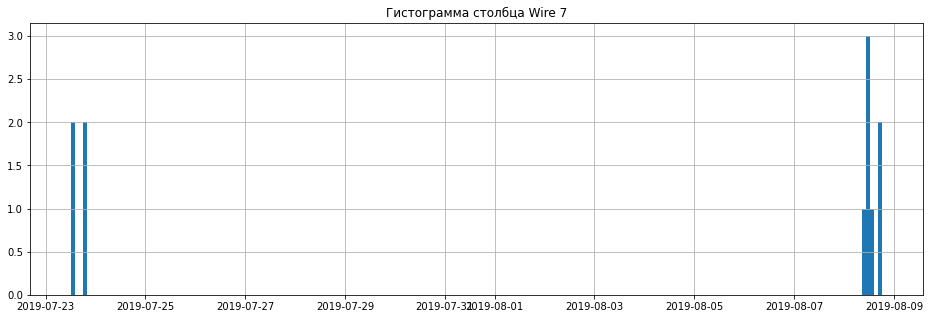

Минимальное значение даты:  2019-07-23 12:08:44
Максимальное значение даты:  2019-08-08 18:27:34


                               ____________ Столбец: Wire 8 ___________



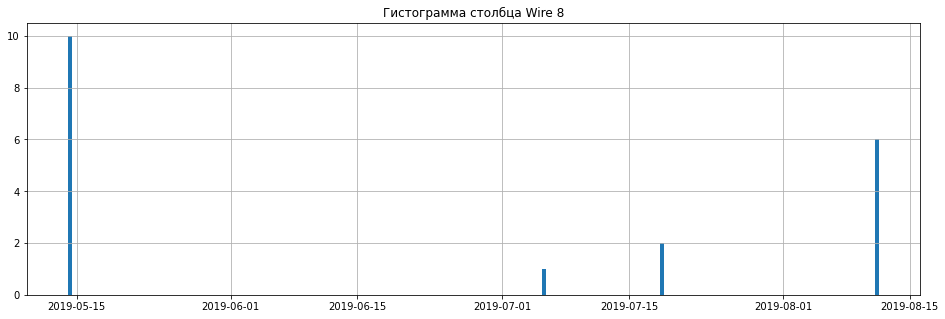

Минимальное значение даты:  2019-05-14 00:03:32
Максимальное значение даты:  2019-08-11 15:09:29


                               ____________ Столбец: Wire 9 ___________



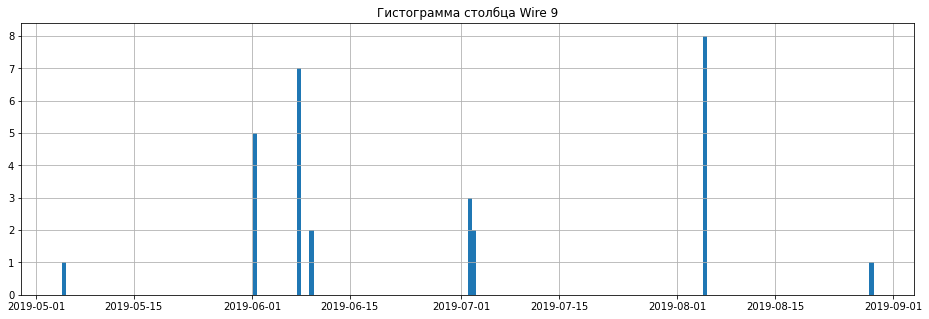

Минимальное значение даты:  2019-05-04 16:09:11
Максимальное значение даты:  2019-08-29 03:51:31




In [26]:
visual(data_wire_time)

##### **Вывод:**
* Общее количество строк: 3081
* 23385 ячеек с пропусками (пропуски соответствуют отсутствию добавления сыпучих материалов)
* Нет дубликатов
* таблица повторяет структуру data_wire
* Столбцы представляют собой время для конкретного проволочного материала, который добавляется в расплав в зависимости от входных химических характеристик сплава (нет добавления проволочного материала — нет времени).
* Наличие времён для выбросов из таблицы data_bulk говорит в пользу того что значения реальны и не являются аномалиями за исключением температур вне технологического процесса.
* Наблюдается временной "провал" по всем столбцам, как и предыдущих таблицах с временем

## Предобработка данных

### Таблица data_arc — "Данные об электродах"

In [27]:
gen_info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708



                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034             0.637371
max     3241.000000           3.731596             2.676388

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4

Добавим столбец с полной мощностью (full_power) и cos φ. По ним можно судить об адекватности нагрузки и в дальнейшем эти столбцы также будут являться признаками для обучения модели. И сразу же избавимся от явных аномалий в столбце Реактивная мощность.
Также добавим столбец со временем нагрева (heating_time) для каждого наблюдения и преобразуем его в секунды (тип float64) и столбец номера недели, чтоб учесть влияние температуры окружающей среды

In [28]:
data_arc['full_power'] = (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2) ** 0.5 
data_arc['cos_φ'] = data_arc['Активная мощность'] / data_arc['full_power']
data_arc['heating_time'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc = data_arc.loc[data_arc['Реактивная мощность'] > 0]
data_arc['heating_time'] = data_arc['heating_time'].dt.total_seconds()
data_arc['week'] = data_arc['Конец нагрева дугой'].dt.week
data_arc['number_of_heatings'] = 1


In [29]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,full_power,cos_φ,heating_time,week,number_of_heatings
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,0.817717,228.0,18,1
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,0.840041,185.0,18,1
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,0.830728,172.0,18,1
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,0.842115,365.0,18,1
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,0.858178,148.0,18,1
...,...,...,...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648,0.833015,157.0,35,1
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559,0.790832,180.0,35,1
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560,0.839164,184.0,35,1
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489,0.834417,57.0,35,1


                               ____________ Столбец: key ___________

count    14875.000000
mean      1615.186756
std        934.593897
min          1.000000
25%        806.000000
50%       1617.000000
75%       2429.000000
max       3241.000000
Name: key, dtype: float64


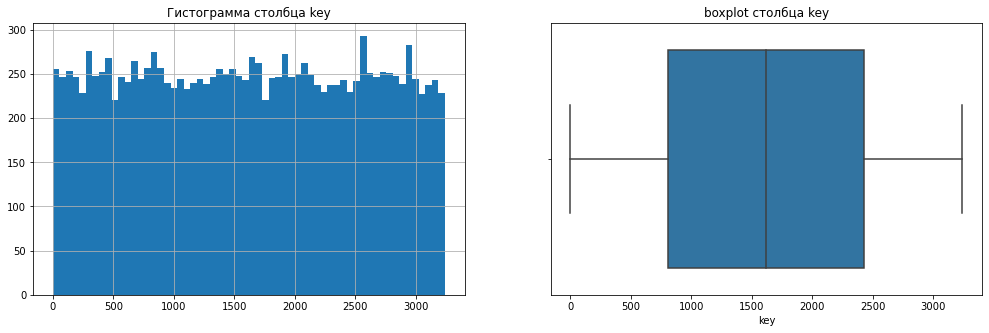


                               ____________ Столбец: Начало нагрева дугой ___________



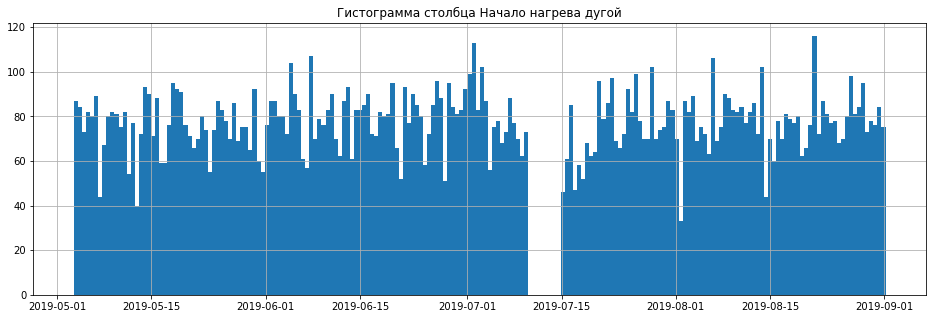

Минимальное значение даты:  2019-05-03 11:02:14
Максимальное значение даты:  2019-09-01 04:34:47


                               ____________ Столбец: Конец нагрева дугой ___________



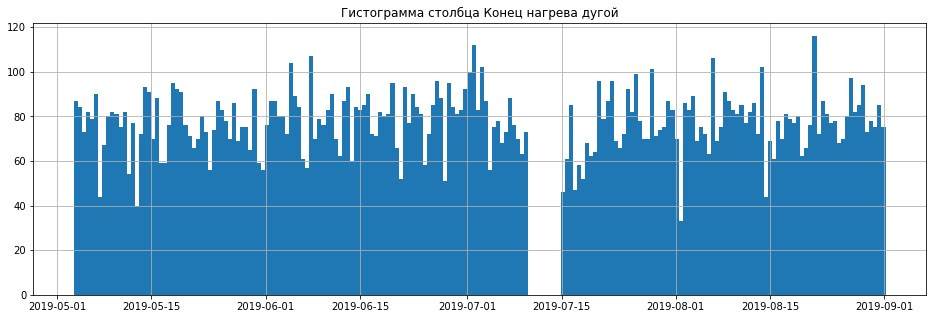

Минимальное значение даты:  2019-05-03 11:06:02
Максимальное значение даты:  2019-09-01 04:36:08


                               ____________ Столбец: Активная мощность ___________

count    14875.000000
mean         0.670453
std          0.408170
min          0.030002
25%          0.395295
50%          0.555565
75%          0.857049
max          3.731596
Name: Активная мощность, dtype: float64


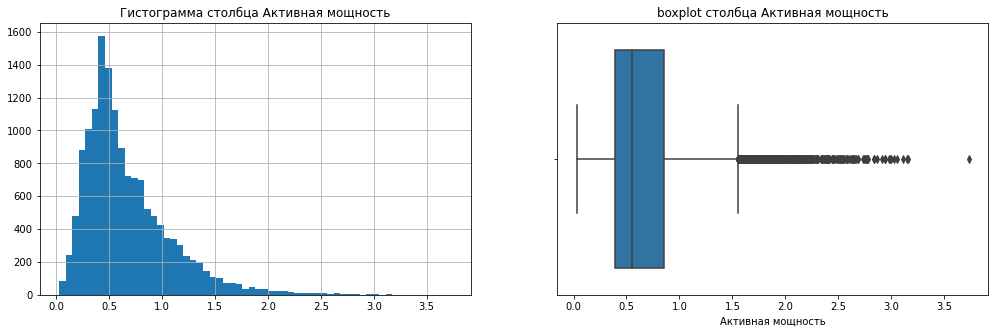


                               ____________ Столбец: Реактивная мощность ___________

count    14875.000000
mean         0.500723
std          0.310880
min          0.020806
25%          0.291003
50%          0.415984
75%          0.637403
max          2.676388
Name: Реактивная мощность, dtype: float64


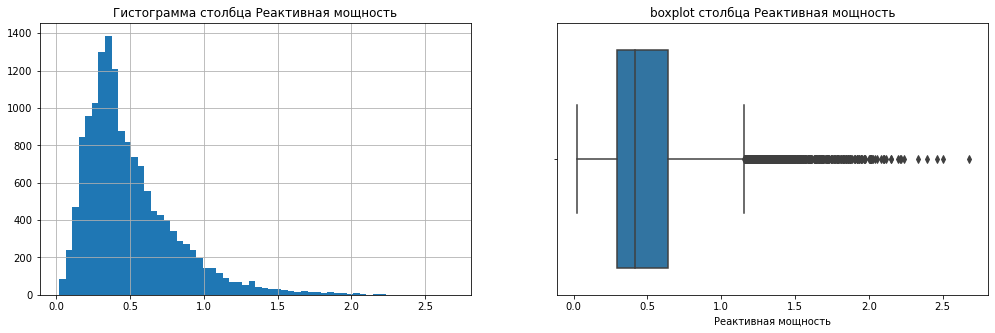


                               ____________ Столбец: full_power ___________

count    14875.000000
mean         0.838768
std          0.509853
min          0.036664
25%          0.495322
50%          0.694926
75%          1.066748
max          4.592152
Name: full_power, dtype: float64


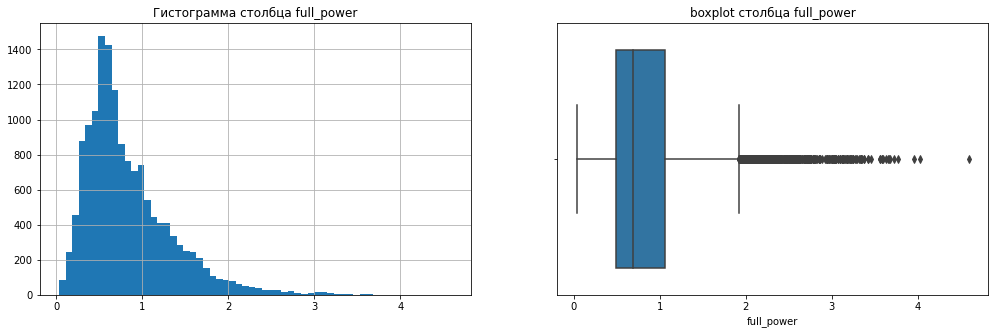


                               ____________ Столбец: cos_φ ___________

count    14875.000000
mean         0.800884
std          0.042884
min          0.416389
25%          0.782597
50%          0.808958
75%          0.828693
max          0.889801
Name: cos_φ, dtype: float64


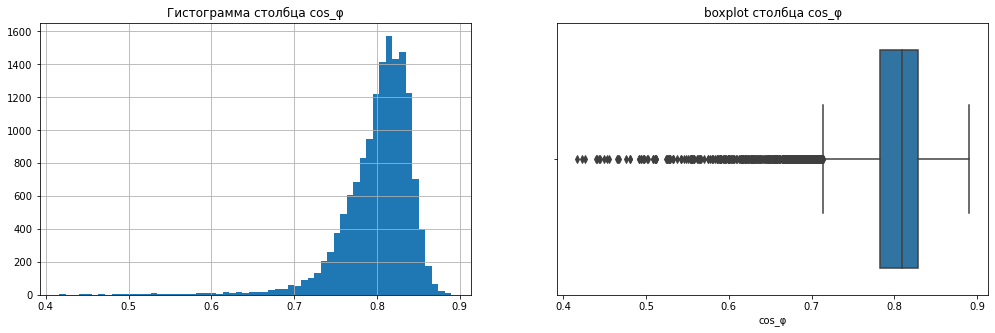


                               ____________ Столбец: heating_time ___________

count    14875.000000
mean       171.675160
std         98.188759
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: heating_time, dtype: float64


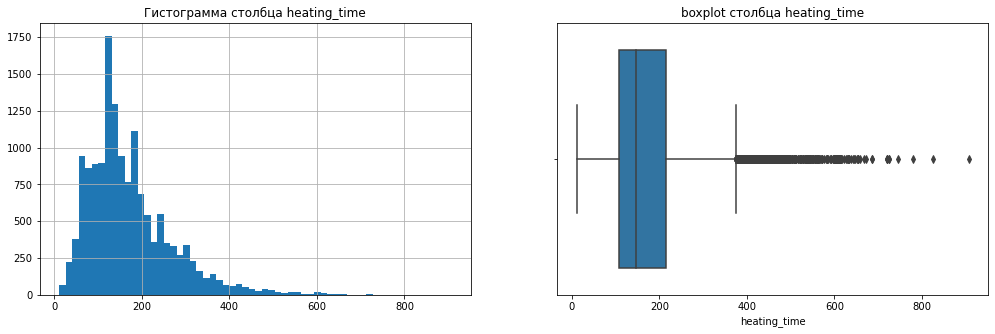


                               ____________ Столбец: week ___________

count    14875.000000
mean        26.738824
std          5.081852
min         18.000000
25%         22.000000
50%         26.000000
75%         31.000000
max         35.000000
Name: week, dtype: float64


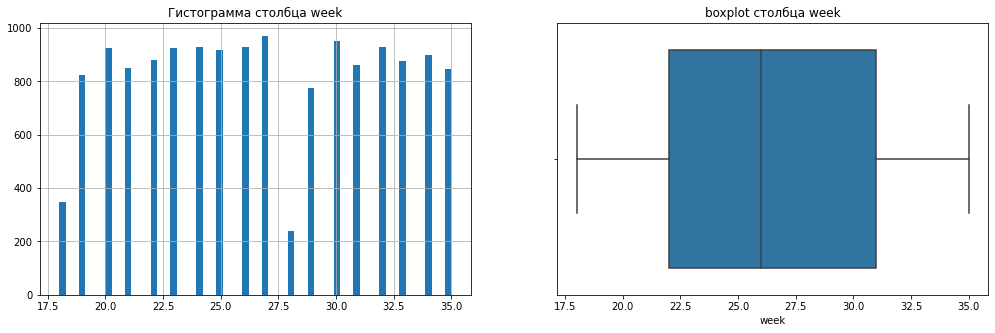


                               ____________ Столбец: number_of_heatings ___________

count    14875.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: number_of_heatings, dtype: float64


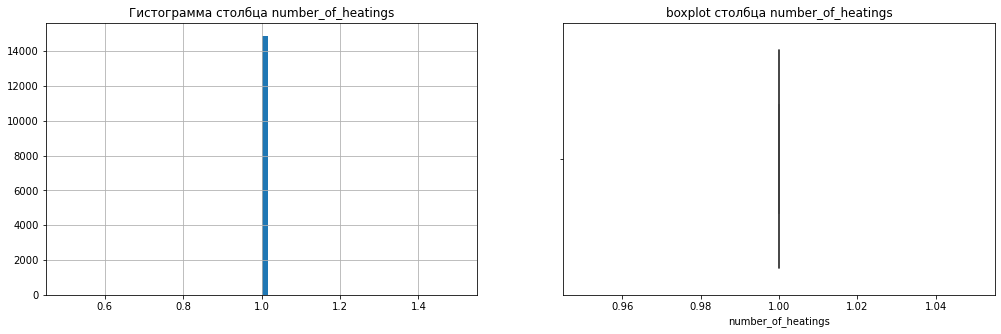

In [30]:
visual(data_arc)

И поменяем названия оставшихся столбцов

In [31]:
data_arc = data_arc.rename(columns = {'Активная мощность':'active_power', 'Реактивная мощность':'reactive_power'})

In [32]:
display(data_arc.head())

,key,Начало нагрева дугой,Конец нагрева дугой,active_power,reactive_power,full_power,cos_φ,heating_time,week,number_of_heatings
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,0.817717,228.0,18,1
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,0.840041,185.0,18,1
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,0.830728,172.0,18,1
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,0.842115,365.0,18,1
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,0.858178,148.0,18,1


Теперь сгруппируем по ключу нужные столбцы

In [33]:
data_arc_made = data_arc.groupby('key', as_index=False).aggregate({'active_power': 'mean'
                                                   ,'reactive_power': 'mean'
                                                   ,'full_power': 'mean'
                                                   ,'cos_φ': 'mean'
                                                   ,'heating_time': 'sum'
                                                   ,'week': 'mean'
                                                   ,'number_of_heatings': 'sum'})

In [34]:
data_arc_made['week'] = data_arc_made['week'].astype('int')

In [35]:
display(data_arc_made.head())

,key,active_power,reactive_power,full_power,cos_φ,heating_time,week,number_of_heatings
0,1,0.975629,0.636648,1.165279,0.837756,1098.0,18,5
1,2,0.763150,0.499528,0.912304,0.840158,811.0,18,4
2,3,0.505176,0.319815,0.597907,0.845421,655.0,18,5
3,4,0.802313,0.515074,0.953741,0.841682,741.0,18,4
4,5,0.836793,0.563161,1.008939,0.828104,869.0,18,4


#### **Вывод:** Таблица для объединения готова

### Таблица data_bulk — "Данные о подаче сыпучих материалов (объём)"

Здесь заменим NaN на 0

In [36]:
print(data_bulk.shape)
data_bulk = data_bulk.fillna(0)
print(data_bulk.shape)

(3129, 16)
(3129, 16)


In [37]:
display(data_bulk.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Откорректируем стиль написания столбцов, для это напишем функцию и будем пользоваться ей для следующих фатафреймов

In [38]:
def snake_case(df):   
    colums = df.columns
    d = dict.fromkeys(colums)
    s = d.keys()
    for i in s:
        if i == 'key':
            d[i] = i
        else:
            d[i] = i.lower().replace(" ", "_")
    return d

In [39]:
data_bulk = data_bulk.rename(columns = snake_case(data_bulk))


In [40]:
data_bulk['bulk_sum'] = data_bulk.sum(axis=1) - data_bulk['key']

In [41]:
display(data_bulk.head())

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


#### **Вывод:** Таблица для объединения готова

### Таблица data_bulk_time — "Данные о подаче сыпучих материалов (время)"

Откорректируем стиль написания стлбцов

In [42]:
data_bulk_time = data_bulk_time.rename(columns = snake_case(data_bulk_time))
display(data_bulk_time.head())

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


Таблицу обрабатывать пока не будем. Возможно не пригодиться 

### Таблица data_gas — "Данные о продувке сплава газом"

Откорректируем стиль написания стлбца

In [43]:
data_gas = data_gas.rename(columns = {'Газ 1':'inert_gas'})
display(data_gas.head())

,key,inert_gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


#### **Вывод:** Таблица для объединения готова

### Таблица data_temp — "Результаты измерения температуры"

Необходимо сформировать таблицу, в которой будет столбец ключ с уникальными значениями (без повторений) ключа, столбец с начальной температурой (пойдет в признак) и столбец с конечной температурой (пойдет в таргет). Остальные (промежуточные значения) отобразим отдельным признаком в виде количества измерений на ключ (плавку).

Для начала удалим строки с аномалиями и поменяем названия столбцов

In [44]:
print(data_temp.shape)
data_temp = data_temp.loc[data_temp['Температура'] >= 1500]
data_temp = data_temp.rename(columns = {'Температура':'temperature', 'Время замера':'measurement_time'})
print(data_temp.shape)

(15907, 3)
(12999, 3)


Посмотрим количество измерений температуры по ключам

In [45]:
count_temp = data_temp.groupby('key').aggregate({'temperature': 'count'}).reset_index()
count_temp['temperature'].value_counts()

1     740
4     652
5     584
3     432
6     369
7     182
8     100
2      56
9      43
10     22
11     16
12     11
16      3
15      3
14      1
13      1
Name: temperature, dtype: int64

740 ключей имеет только одно измерение температуры. Посмотрим на них.

In [46]:
one_temp = count_temp[count_temp['temperature'] == 1]['key']
display(data_temp[data_temp['key'].isin(one_temp)].head(6))

,key,measurement_time,temperature
1100,195,2019-05-10 14:10:23,1583.0
1554,279,2019-05-13 23:07:28,1603.0
12267,2500,2019-08-06 03:11:31,1539.0
12271,2501,2019-08-06 03:44:42,1587.0
12276,2502,2019-08-06 04:45:26,1583.0
12283,2503,2019-08-06 05:32:06,1603.0


                               ____________ Столбец: key ___________

count     740.000000
mean     2863.154054
std       253.592954
min       195.000000
25%      2684.750000
50%      2869.500000
75%      3054.250000
max      3241.000000
Name: key, dtype: float64


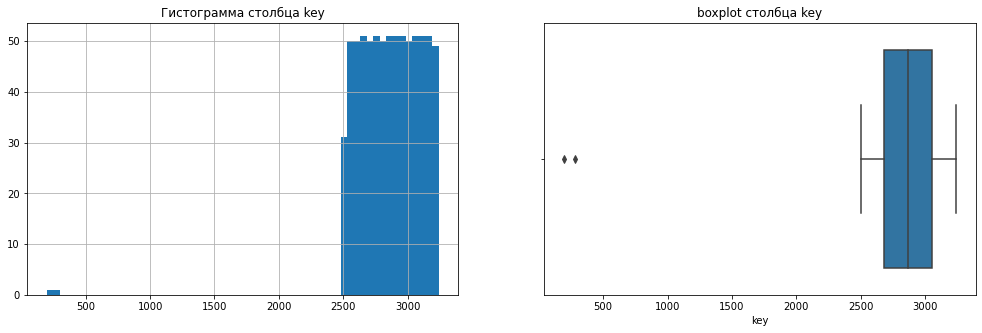


                               ____________ Столбец: measurement_time ___________



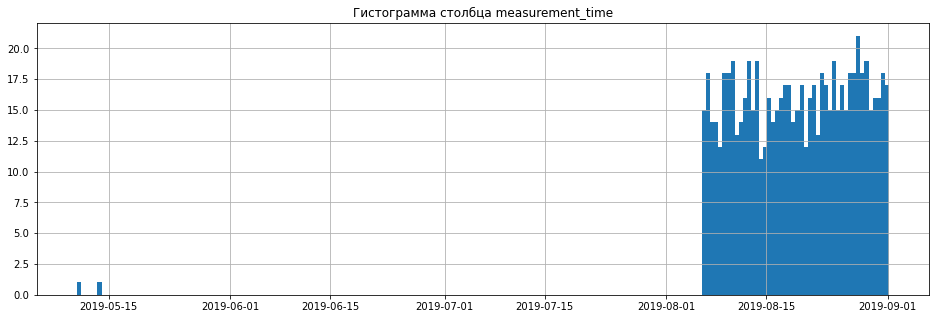

Минимальное значение даты:  2019-05-10 14:10:23
Максимальное значение даты:  2019-09-01 04:03:30


                               ____________ Столбец: temperature ___________

count     740.000000
mean     1589.747297
std        25.080756
min      1529.000000
25%      1573.000000
50%      1588.000000
75%      1607.000000
max      1684.000000
Name: temperature, dtype: float64


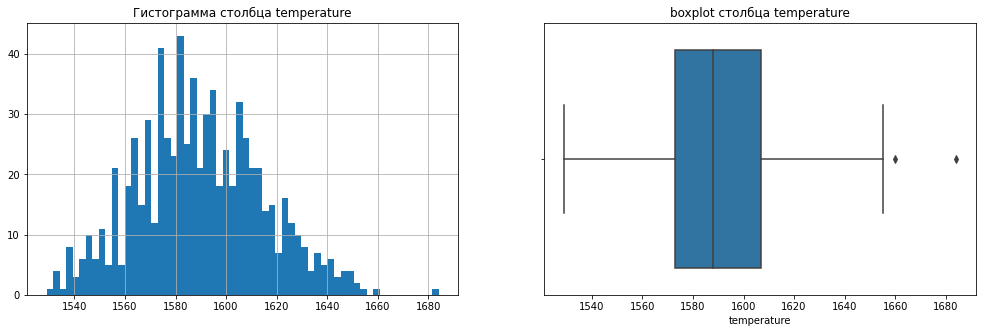

In [47]:
visual(data_temp[data_temp['key'].isin(one_temp)])

Два значения ключа 195 и 279 имеет только одно значение(ячейку) температуры, остальные с 2500 по 3241 тоже по одной температуре (первой) плюс пропуски. Т.е. данные с этими ключами использовать не получится (нет таргета). Поэтому удалим строки с этими ключами.

In [48]:
print(data_temp.shape)
data_temp = data_temp.drop(data_temp[data_temp['key'].isin(one_temp)].index)
print(data_temp.shape)
display(data_temp.head(15))

(12999, 3)
(12259, 3)


,key,measurement_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Теперь сгруппируем Время по ключу для получения только первого времени и сгруппируем Время по ключу для получения только последнего времени и колличества измерений по ключу

In [49]:
first_time = data_temp.groupby('key', as_index=False).aggregate({'measurement_time': 'min'})
count_time = data_temp.groupby('key', as_index=False).aggregate({'temperature': 'count'})
final_time = data_temp.groupby('key', as_index=False).aggregate({'measurement_time': 'max'})

In [50]:
count_time

,key,temperature
0,1,5
1,2,6
2,3,5
3,4,3
4,5,2
...,...,...
2470,2495,3
2471,2496,4
2472,2497,2
2473,2498,5


Теперь оставим из таблицы записи для начального времени и запишем в новую таблицу и оставим из таблицы записи для конечного времени и запишем в новую таблицу

In [51]:
data_temp_first = data_temp[data_temp['measurement_time'].isin(first_time['measurement_time'].values)]
data_temp_first = data_temp_first.rename(columns = {'temperature':'first_temperature'})
data_temp_first.pop('measurement_time')
print(data_temp_first.shape)
print('Общее количество ячеек с пропусками:', data_temp_first.isna().sum().sum())
display(data_temp_first.head())

data_temp_final = data_temp[data_temp['measurement_time'].isin(final_time['measurement_time'].values)]
data_temp_final = data_temp_final.rename(columns = {'temperature':'final_temperature'})
data_temp_final.pop('measurement_time')
print(data_temp_final.shape)
print('Общее количество ячеек с пропусками:', data_temp_final.isna().sum().sum())
display(data_temp_final.head())

count_time = count_time.rename(columns = {'temperature':'count_time'})
print(count_time.shape)
print('Общее количество ячеек с пропусками:', count_time.isna().sum().sum())
display(count_time.head())

(2475, 2)
Общее количество ячеек с пропусками: 0


,key,first_temperature
0,1,1571.0
5,2,1581.0
11,3,1596.0
16,4,1601.0
19,5,1576.0


(2475, 2)
Общее количество ячеек с пропусками: 0


,key,final_temperature
4,1,1613.0
10,2,1602.0
15,3,1599.0
18,4,1625.0
20,5,1602.0


(2475, 2)
Общее количество ячеек с пропусками: 0


,key,count_time
0,1,5
1,2,6
2,3,5
3,4,3
4,5,2


Объединим в одну таблицу

In [52]:
data_temp_made = data_temp_first.merge(data_temp_final, on='key', how='right')
data_temp_made = data_temp_made.merge(count_time, on='key', how='right')
display(data_temp_made.head())
print(data_temp_made.shape)

,key,first_temperature,final_temperature,count_time
0,1,1571.0,1613.0,5
1,2,1581.0,1602.0,6
2,3,1596.0,1599.0,5
3,4,1601.0,1625.0,3
4,5,1576.0,1602.0,2


(2475, 4)


#### **Вывод:** Таблица для объединения готова

### Таблица data_wire — "Данные о проволочных материалах (объём)"

Здесь заменим NaN на 0 и откорректируем стиль написания столбцов

In [53]:
print(data_wire.shape)
data_wire = data_wire.fillna(0)
print(data_wire.shape)
print('Общее количество ячеек с пропусками:', data_wire.isna().sum().sum())
data_wire = data_wire.rename(columns = snake_case(data_wire))
display(data_wire.head())

(3081, 10)
(3081, 10)
Общее количество ячеек с пропусками: 0


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
data_wire['wire_sum'] = data_wire.sum(axis=1) - data_wire['key']
display(data_wire.head())

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


#### **Вывод:** Таблица для объединения готова

### Таблица data_wire_time — "Данные о проволочных материалах (время)"

Таблицу обрабатывать пока не будем. Возможно не пригодиться. Только откорректируем стиль написания столбцов

In [55]:
data_wire_time  = data_wire_time .rename(columns = snake_case(data_wire_time ))
display(data_wire_time.head())

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


### Объеденим готовые таблицы в одну

In [56]:
print('data_arc_made', data_arc_made.shape)
print('data_bulk', data_bulk.shape)
print('data_gas', data_gas.shape)
print('data_temp_made', data_temp_made.shape)
print('data_wire', data_wire.shape)

df = data_arc_made.merge(data_bulk, on='key', how='inner')
df = df.merge(data_gas, on='key', how='inner')
df = df.merge(data_temp_made, on='key', how='inner')
df = df.merge(data_wire, on='key', how='inner')
df.pop('key')

print('df', df.shape)
print('Общее количество ячеек с пропусками:', df.isna().sum().sum())

data_arc_made (3214, 8)
data_bulk (3129, 17)
data_gas (3239, 2)
data_temp_made (2475, 4)
data_wire (3081, 11)
df (2329, 37)
Общее количество ячеек с пропусками: 0


### Исследование объединённого датафрейма.

In [57]:
gen_info(df)

,active_power,reactive_power,full_power,cos_φ,heating_time,week,number_of_heatings,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,inert_gas,first_temperature,final_temperature,count_time,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum
0,0.975629,0.636648,1.165279,0.837756,1098.0,18,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,29.749986,1571.0,1613.0,5,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,0.763150,0.499528,0.912304,0.840158,811.0,18,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,12.555561,1581.0,1602.0,6,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,0.505176,0.319815,0.597907,0.845421,655.0,18,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,28.554793,1596.0,1599.0,5,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,0.802313,0.515074,0.953741,0.841682,741.0,18,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,18.841219,1601.0,1625.0,3,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,0.836793,0.563161,1.008939,0.828104,869.0,18,4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,5.413692,1576.0,1602.0,2,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


,active_power,reactive_power,full_power,cos_φ,heating_time,week,number_of_heatings,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,inert_gas,first_temperature,final_temperature,count_time,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum
2324,0.802673,0.590194,0.996717,0.807313,723.0,32,4,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,719.0,7.125735,1570.0,1591.0,3,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.150879
2325,0.700511,0.468364,0.842839,0.829826,940.0,32,6,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,796.0,9.412616,1554.0,1591.0,4,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.179527
2326,0.737460,0.617090,0.961672,0.765895,569.0,32,3,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,665.0,6.271699,1571.0,1589.0,2,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.134723
2327,0.681745,0.471086,0.828750,0.826522,750.0,32,5,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,733.0,14.953657,1591.0,1594.0,5,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.110717
2328,1.024608,0.694466,1.238253,0.828846,883.0,32,4,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0,633.0,11.336151,1569.0,1603.0,3,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.166238



       active_power  reactive_power   full_power        cos_φ  heating_time  \
count   2329.000000     2329.000000  2329.000000  2329.000000   2329.000000   
mean       0.669044        0.499276     0.836618     0.801381    807.600687   
std        0.196943        0.147383     0.242350     0.032182    340.897332   
min        0.186226        0.130062     0.228541     0.552784     57.000000   
25%        0.526430        0.392506     0.659957     0.789938    581.000000   
50%        0.644404        0.487685     0.815558     0.806903    778.000000   
75%        0.792065        0.592351     0.986384     0.820589    993.000000   
max        1.421416        1.134983     1.796257     0.869155   4189.000000   

              week  number_of_heatings       bulk_1       bulk_2       bulk_3  \
count  2329.000000         2329.000000  2329.000000  2329.000000  2329.000000   
mean     24.753542            4.695148     3.427651     1.422499    47.348218   
std       3.891822            1.606948    12

                               ____________ Столбец: active_power ___________

count    2329.000000
mean        0.669044
std         0.196943
min         0.186226
25%         0.526430
50%         0.644404
75%         0.792065
max         1.421416
Name: active_power, dtype: float64


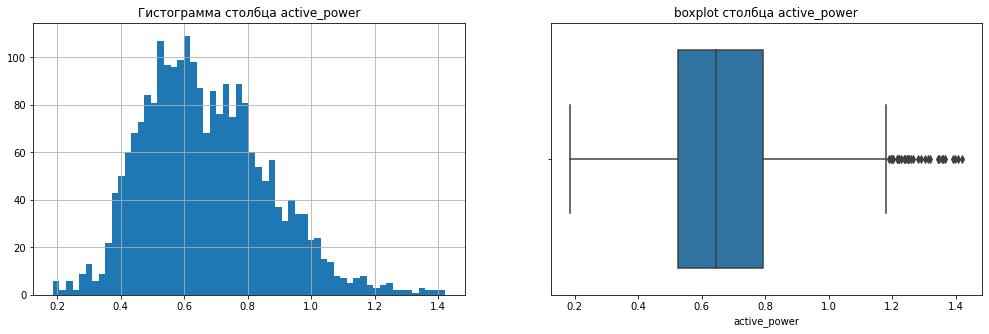


                               ____________ Столбец: reactive_power ___________

count    2329.000000
mean        0.499276
std         0.147383
min         0.130062
25%         0.392506
50%         0.487685
75%         0.592351
max         1.134983
Name: reactive_power, dtype: float64


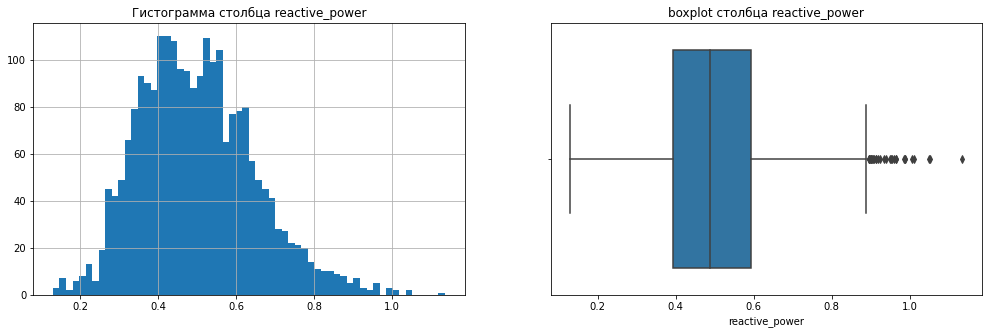


                               ____________ Столбец: full_power ___________

count    2329.000000
mean        0.836618
std         0.242350
min         0.228541
25%         0.659957
50%         0.815558
75%         0.986384
max         1.796257
Name: full_power, dtype: float64


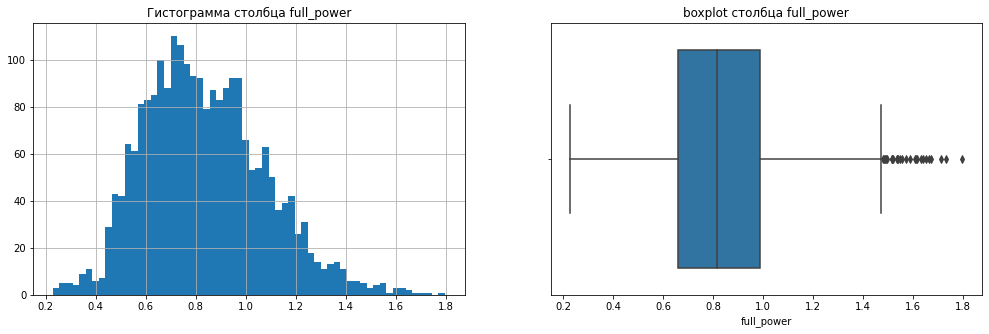


                               ____________ Столбец: cos_φ ___________

count    2329.000000
mean        0.801381
std         0.032182
min         0.552784
25%         0.789938
50%         0.806903
75%         0.820589
max         0.869155
Name: cos_φ, dtype: float64


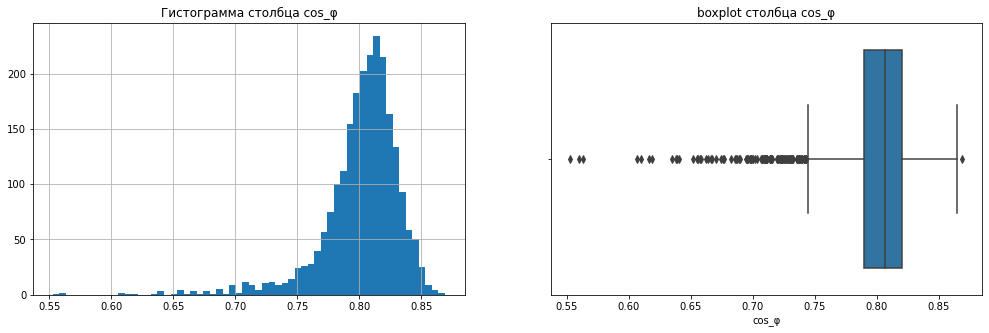


                               ____________ Столбец: heating_time ___________

count    2329.000000
mean      807.600687
std       340.897332
min        57.000000
25%       581.000000
50%       778.000000
75%       993.000000
max      4189.000000
Name: heating_time, dtype: float64


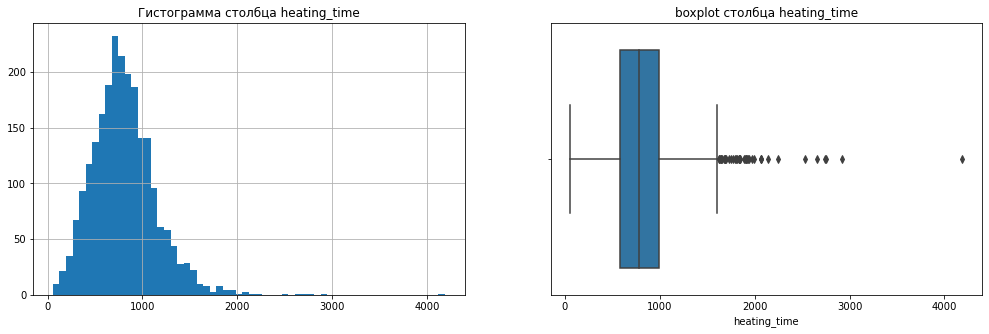


                               ____________ Столбец: number_of_heatings ___________

count    2329.000000
mean        4.695148
std         1.606948
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        16.000000
Name: number_of_heatings, dtype: float64


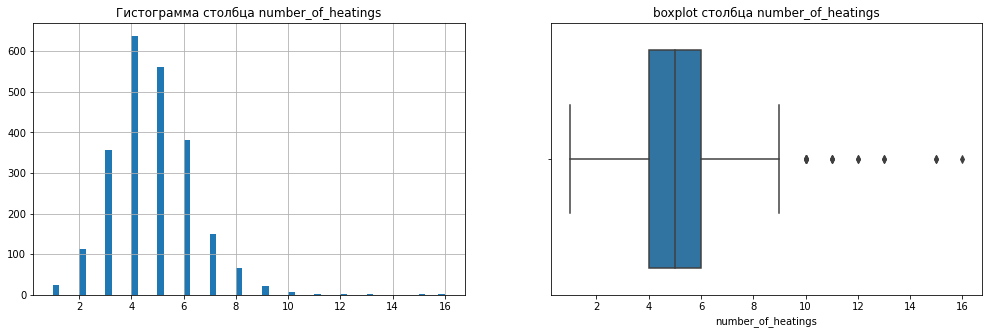


                               ____________ Столбец: bulk_1 ___________

count    2329.000000
mean        3.427651
std        12.412132
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       185.000000
Name: bulk_1, dtype: float64


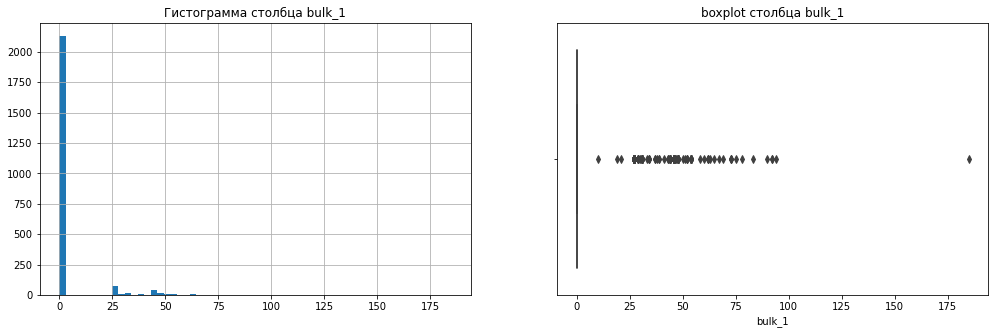


                               ____________ Столбец: bulk_2 ___________

count    2329.000000
mean        1.422499
std        19.082119
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       325.000000
Name: bulk_2, dtype: float64


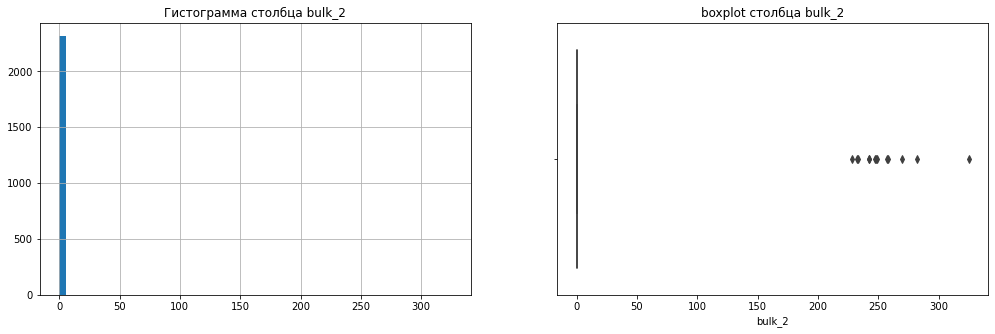


                               ____________ Столбец: bulk_3 ___________

count    2329.000000
mean       47.348218
std        75.310430
min         0.000000
25%         0.000000
50%         0.000000
75%        80.000000
max       454.000000
Name: bulk_3, dtype: float64


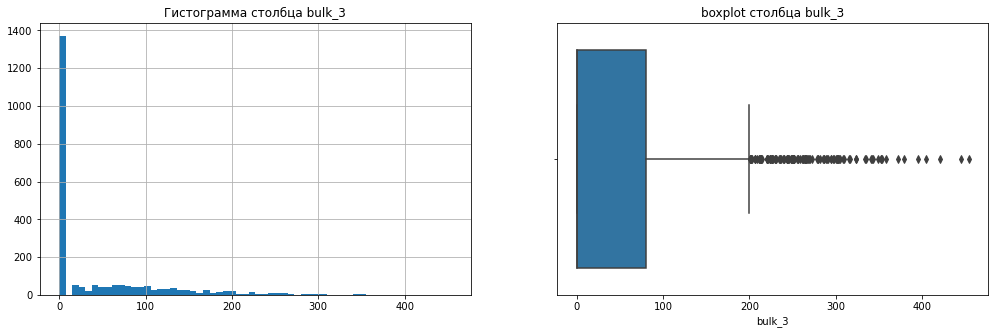


                               ____________ Столбец: bulk_4 ___________

count    2329.000000
mean       37.303564
std        58.643238
min         0.000000
25%         0.000000
50%         0.000000
75%        77.000000
max       281.000000
Name: bulk_4, dtype: float64


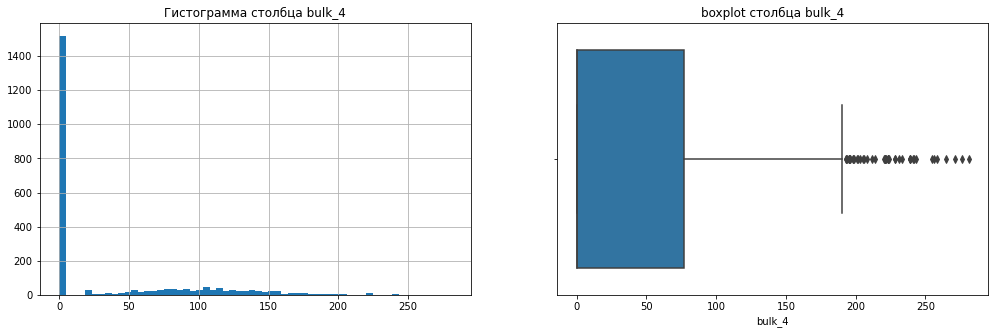


                               ____________ Столбец: bulk_5 ___________

count    2329.000000
mean        2.640189
std        22.402293
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       603.000000
Name: bulk_5, dtype: float64


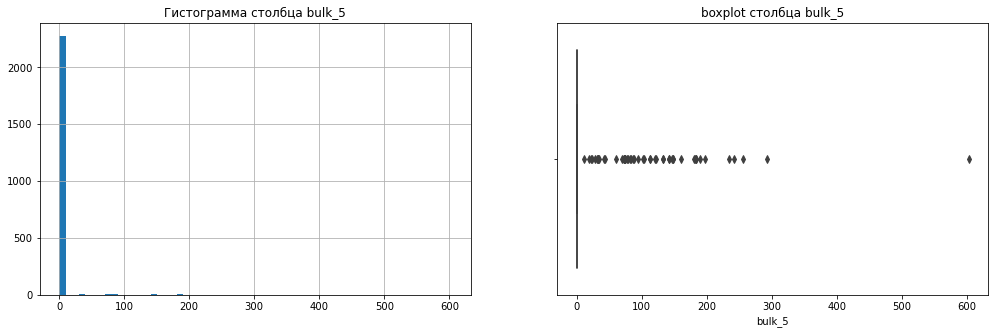


                               ____________ Столбец: bulk_6 ___________

count    2329.000000
mean       22.430228
std        55.790873
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       503.000000
Name: bulk_6, dtype: float64


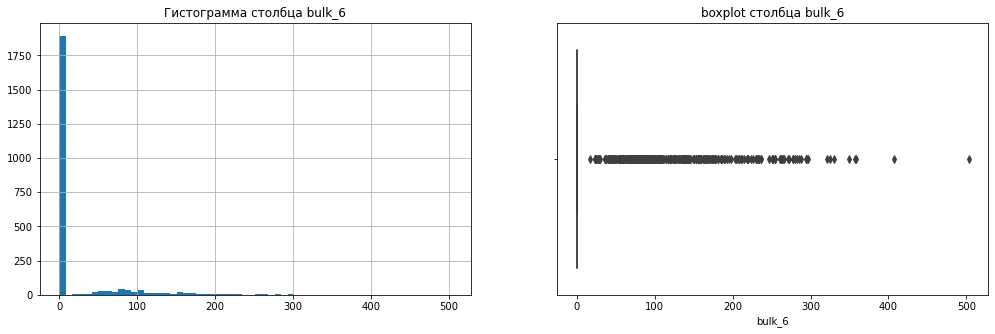


                               ____________ Столбец: bulk_7 ___________

count    2329.000000
mean        2.004723
std        30.676234
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       772.000000
Name: bulk_7, dtype: float64


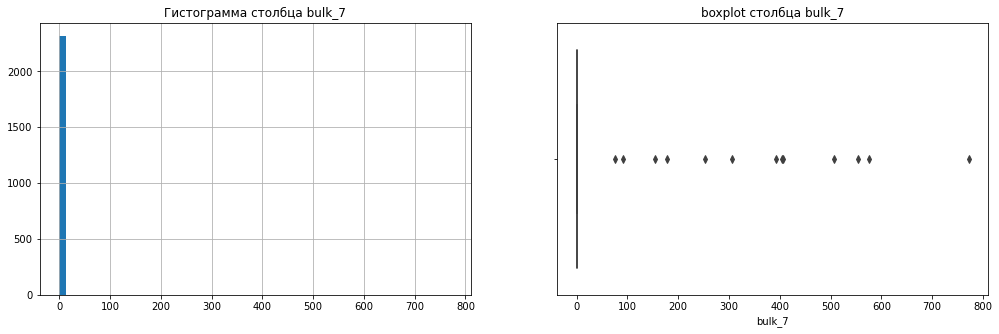


                               ____________ Столбец: bulk_8 ___________

count    2329.000000
mean        0.021039
std         1.015340
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        49.000000
Name: bulk_8, dtype: float64


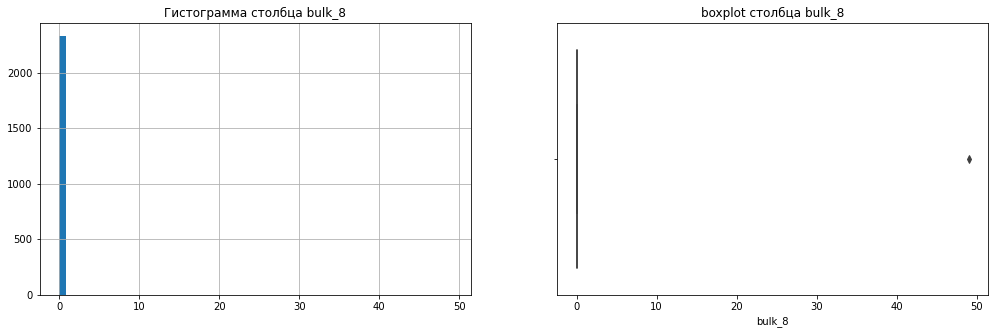


                               ____________ Столбец: bulk_9 ___________

count    2329.000000
mean        0.444826
std         6.220641
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       147.000000
Name: bulk_9, dtype: float64


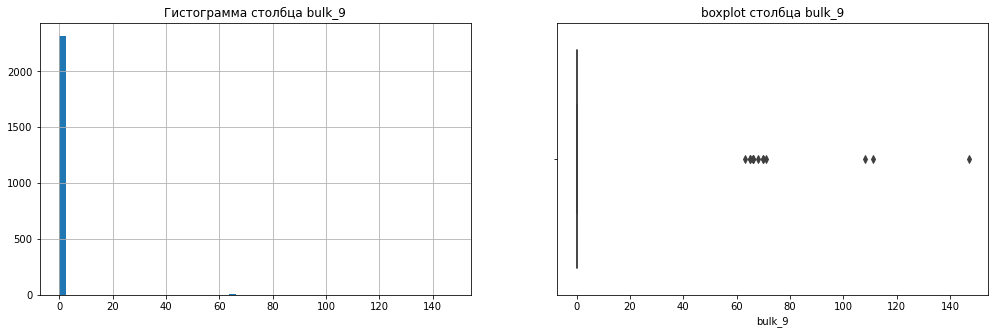


                               ____________ Столбец: bulk_10 ___________

count    2329.000000
mean        5.052812
std        20.917800
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       159.000000
Name: bulk_10, dtype: float64


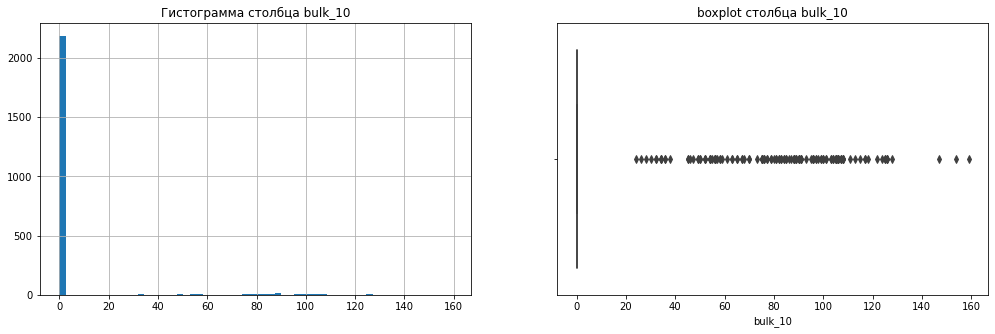


                               ____________ Столбец: bulk_11 ___________

count    2329.000000
mean        4.245170
std        22.515487
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       313.000000
Name: bulk_11, dtype: float64


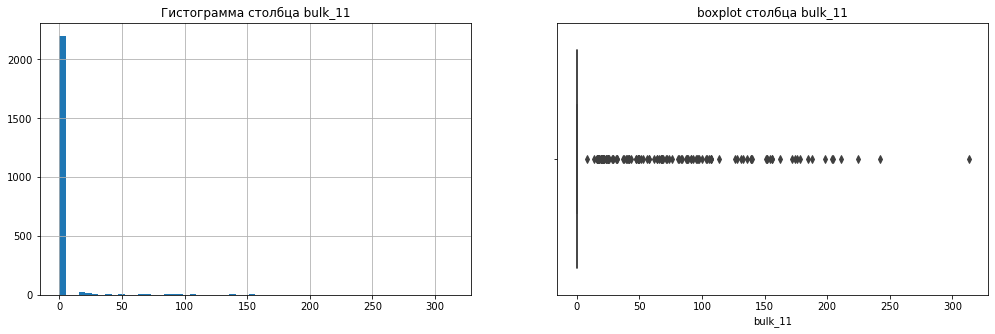


                               ____________ Столбец: bulk_12 ___________

count    2329.000000
mean      208.415629
std       157.062272
min         0.000000
25%       105.000000
50%       206.000000
75%       282.000000
max      1849.000000
Name: bulk_12, dtype: float64


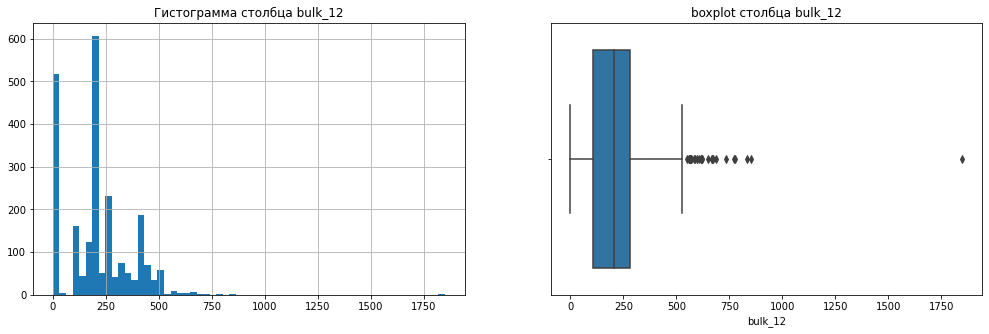


                               ____________ Столбец: bulk_13 ___________

count    2329.000000
mean        1.067411
std        14.235055
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       305.000000
Name: bulk_13, dtype: float64


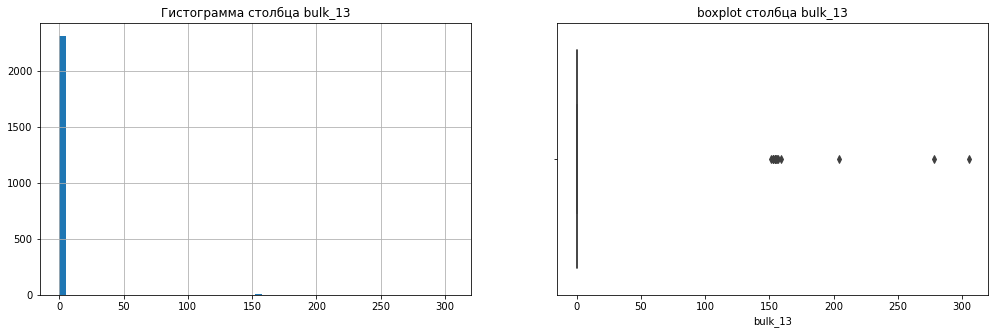


                               ____________ Столбец: bulk_14 ___________

count    2329.000000
mean      153.853585
std        81.404354
min         0.000000
25%       105.000000
50%       149.000000
75%       204.000000
max       636.000000
Name: bulk_14, dtype: float64


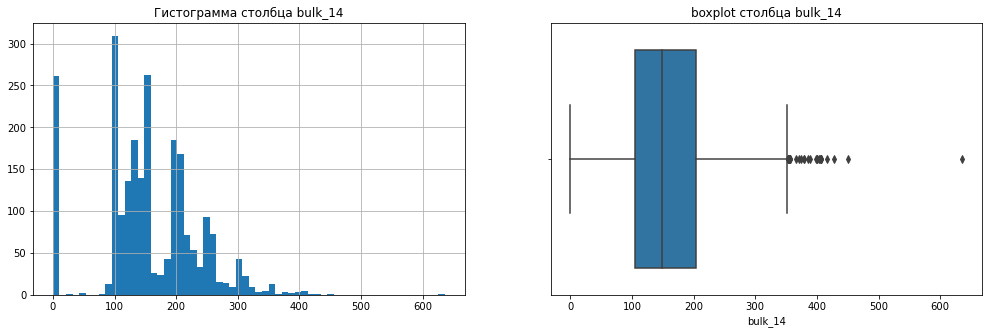


                               ____________ Столбец: bulk_15 ___________

count    2329.000000
mean      119.952769
std        84.640443
min         0.000000
25%         0.000000
50%       107.000000
75%       204.000000
max       405.000000
Name: bulk_15, dtype: float64


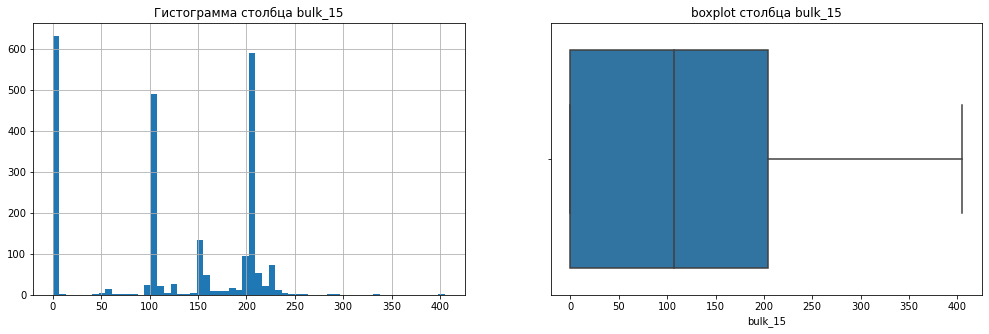


                               ____________ Столбец: bulk_sum ___________

count    2329.000000
mean      609.630313
std       287.599678
min        19.000000
25%       440.000000
50%       609.000000
75%       795.000000
max      3235.000000
Name: bulk_sum, dtype: float64


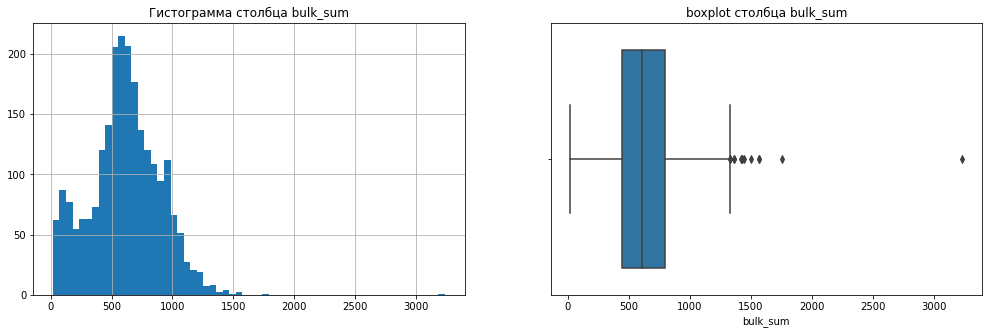


                               ____________ Столбец: inert_gas ___________

count    2329.000000
mean       11.375600
std         6.392041
min         0.008399
25%         7.282948
50%        10.100950
75%        14.216688
max        77.995040
Name: inert_gas, dtype: float64


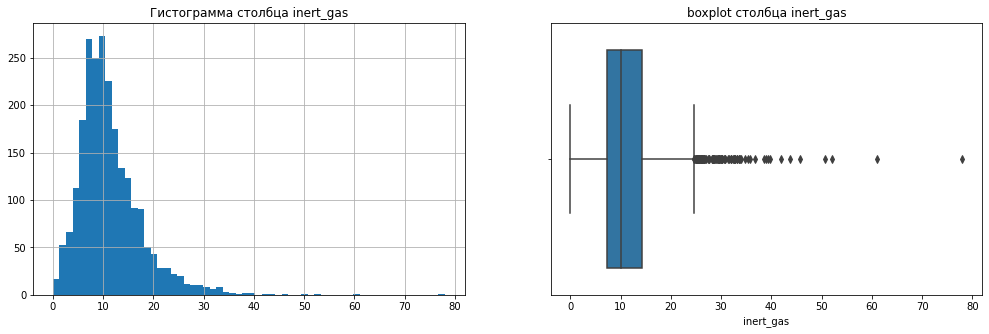


                               ____________ Столбец: first_temperature ___________

count    2329.000000
mean     1587.386003
std        23.619841
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: first_temperature, dtype: float64


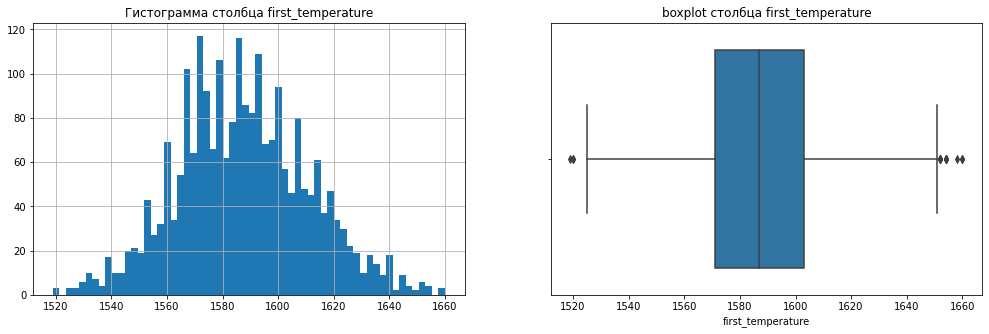


                               ____________ Столбец: final_temperature ___________

count    2329.000000
mean     1593.365393
std        11.200915
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: final_temperature, dtype: float64


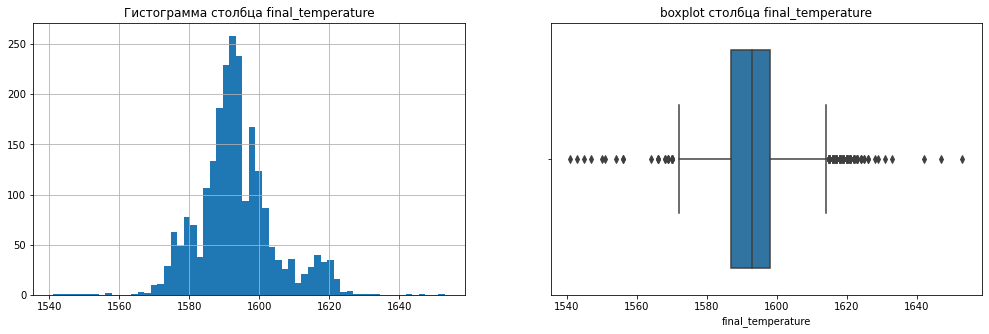


                               ____________ Столбец: count_time ___________

count    2329.000000
mean        4.982825
std         1.794574
min         2.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        16.000000
Name: count_time, dtype: float64


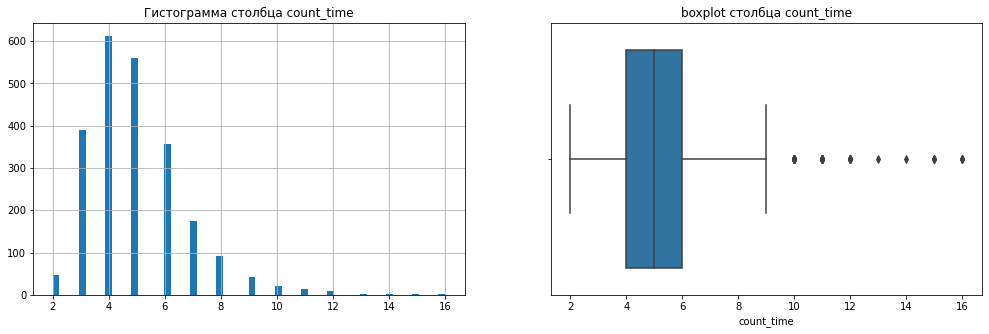


                               ____________ Столбец: wire_1 ___________

count    2329.000000
mean      102.443601
std        43.539993
min         0.000000
25%        73.207679
50%       101.119201
75%       128.091599
max       330.314424
Name: wire_1, dtype: float64


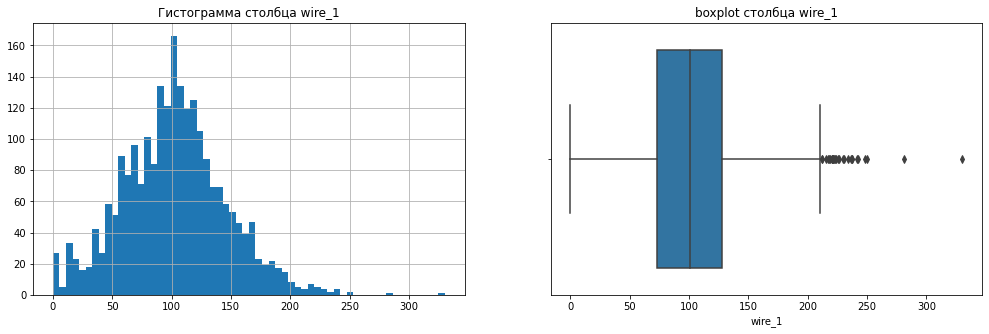


                               ____________ Столбец: wire_2 ___________

count    2329.000000
mean       17.609859
std        33.624771
min         0.000000
25%         0.000000
50%         0.000000
75%        23.102560
max       282.780152
Name: wire_2, dtype: float64


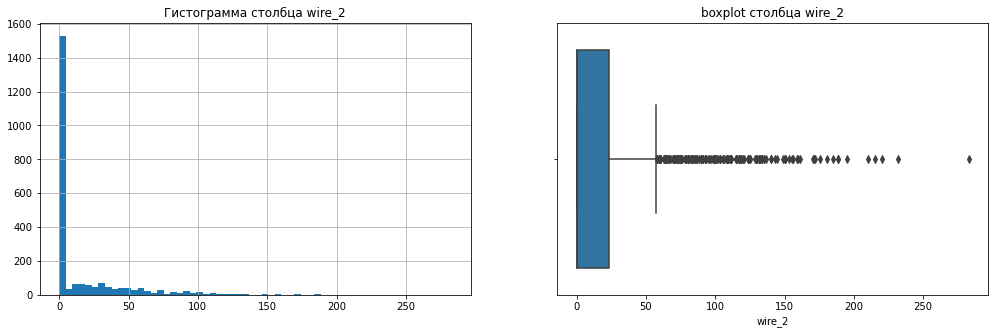


                               ____________ Столбец: wire_3 ___________

count    2329.000000
mean        3.234916
std        27.942871
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       385.008668
Name: wire_3, dtype: float64


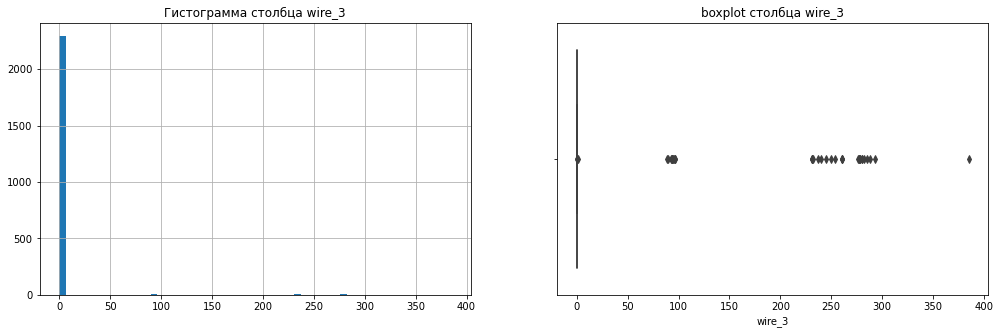


                               ____________ Столбец: wire_4 ___________

count    2329.000000
mean        0.306550
std         4.757746
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       113.231044
Name: wire_4, dtype: float64


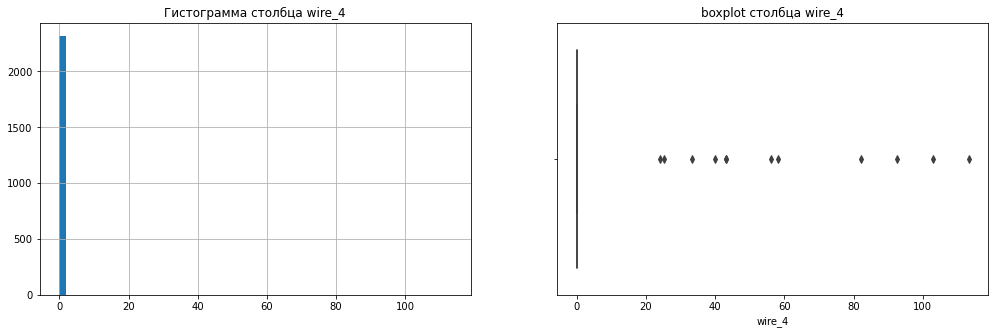


                               ____________ Столбец: wire_5 ___________

count    2329.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: wire_5, dtype: float64


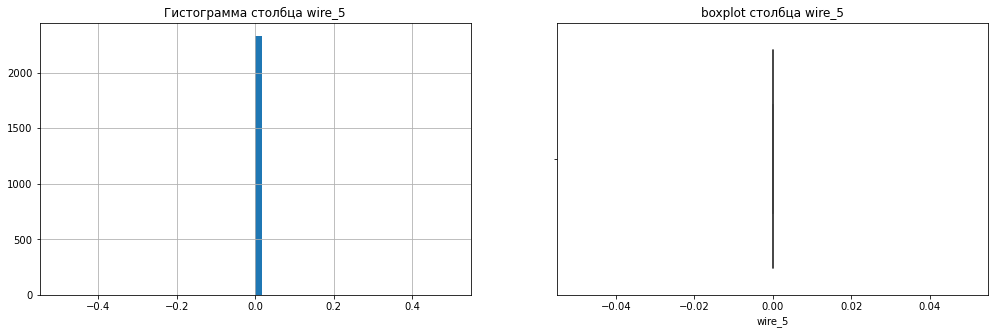


                               ____________ Столбец: wire_6 ___________

count    2329.000000
mean        0.978820
std         8.693299
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       180.454575
Name: wire_6, dtype: float64


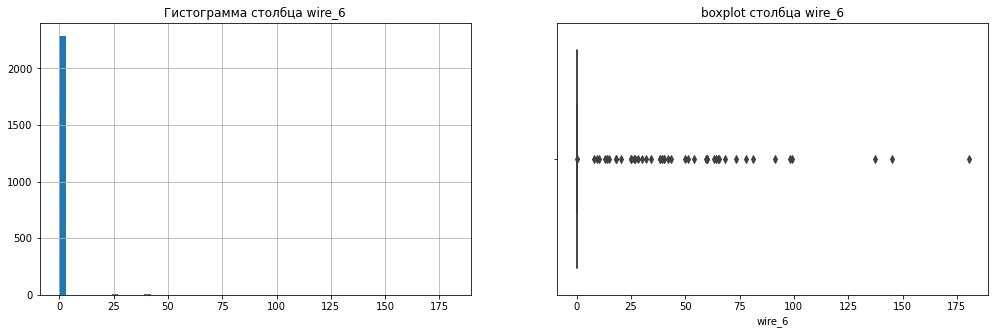


                               ____________ Столбец: wire_7 ___________

count    2329.000000
mean        0.006361
std         0.205705
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.490040
Name: wire_7, dtype: float64


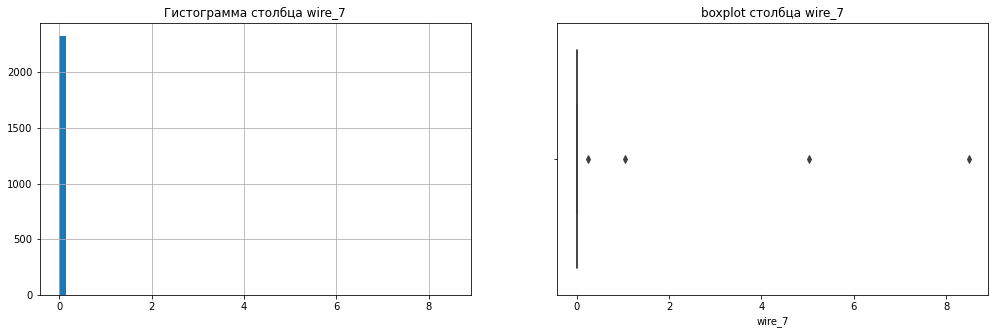


                               ____________ Столбец: wire_8 ___________

count    2329.000000
mean        0.311311
std         4.402707
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       102.762401
Name: wire_8, dtype: float64


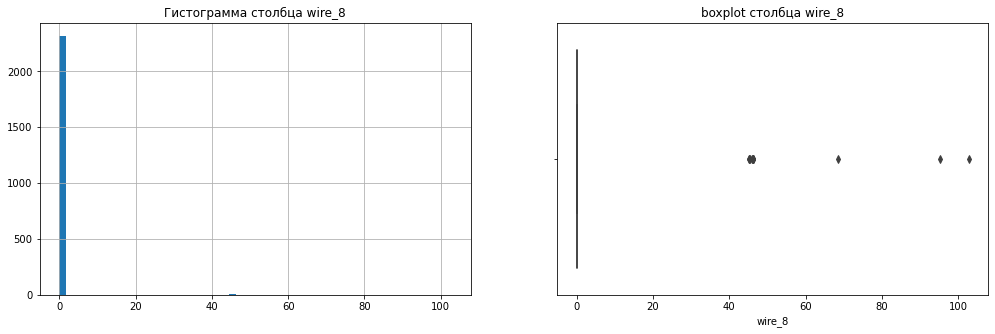


                               ____________ Столбец: wire_9 ___________

count    2329.000000
mean        0.317113
std         3.456561
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        62.025600
Name: wire_9, dtype: float64


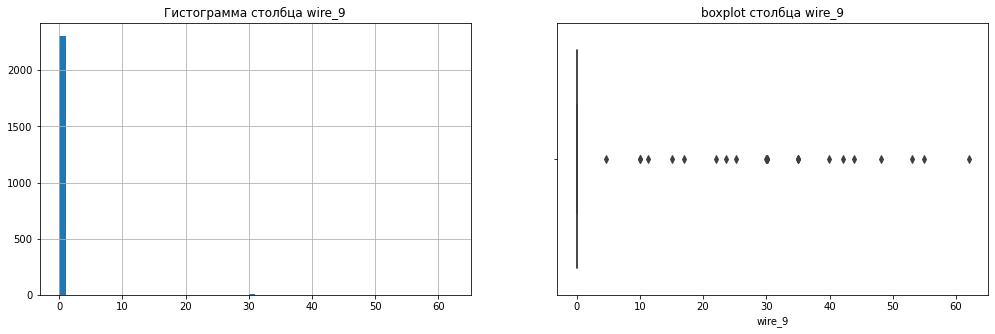


                               ____________ Столбец: wire_sum ___________

count    2329.000000
mean      125.208530
std        63.683386
min         1.918800
25%        89.013596
50%       116.101440
75%       151.568558
max       568.777664
Name: wire_sum, dtype: float64


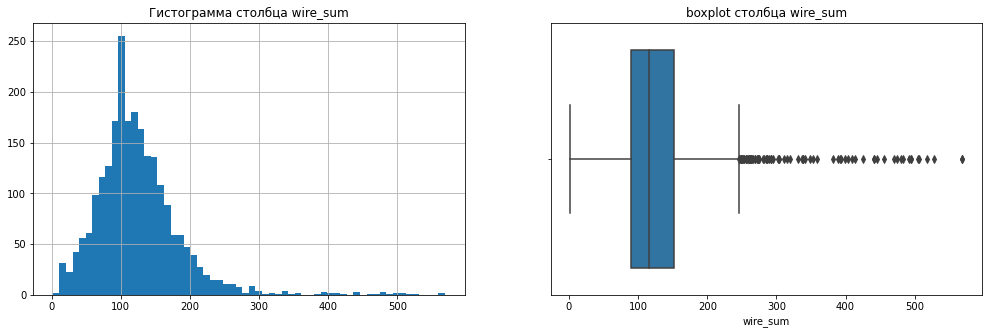

In [58]:
visual(df)

Проверим не имеют ли какие-либо столбцы нашей таблицы нормальное распределение с помощью статистических тестов Шапиро-Уилк и Критерий согласия Пирсона. Для этого напишем функцию проверки на нормальность распределения по всем столбцам датафрейма с выводом результатов в виде таблицы где:
* минус ( — ) значит отклонить гипотезу о нормальности
* плюс (  +  ) означает принять гипотезу о нормальности
* или ( наблюдений < 40 ) когда наблюдений меньше сорока то проводить тест и говорить о распределении невозможно из-за малого количества наблюдений

In [59]:
def stat_test(df, alpha=0.05):
    columns_df = df.columns
    values = []
    
    for col in columns_df:
        if df[df[col] != 0][col].count() < 40:
            shapiro = 'наблюдений < 40'
            normal = 'наблюдений < 40'
        elif df[col].dtypes == 'O':
            shapiro = 'категориальные данные'
            normal = 'категориальные данные'
        else:    
            stat, p_shapiro = scipy.stats.shapiro(df[col]) # тест Шапиро-Уилк 
            #print('Statistics=%.3f, p-value=%.3f' % (stat, p_shapiro))
            if p_shapiro > alpha:
                shapiro = '+'
            else:
                shapiro = '—'

            stat, p_normal = scipy.stats.normaltest(df[col]) # Критерий согласия Пирсона
            #print('Statistics=%.3f, p-value=%.3f' % (stat, p_normal)) 
            if p_normal > alpha:
                normal = '+'
            else:
                normal = '—'
                
        values.append([shapiro, normal])
    report = pd.DataFrame(
        values,
        index = columns_df,
        columns = [
                'Тест Шапиро-Уилк', 
                'Критерий согласия Пирсона'
        ]
    )
    display(report)   

In [60]:
stat_test(df)

,Тест Шапиро-Уилк,Критерий согласия Пирсона
active_power,—,—
reactive_power,—,—
full_power,—,—
cos_φ,—,—
heating_time,—,—
week,—,—
number_of_heatings,—,—
bulk_1,—,—
bulk_2,наблюдений < 40,наблюдений < 40
bulk_3,—,—


Ни один столбец не имеет нормального распределения, значит для анализа мультиколлинеарности воспользуемся методом  Спирмена

#### Анализ мультиколлинеарности

<AxesSubplot:>

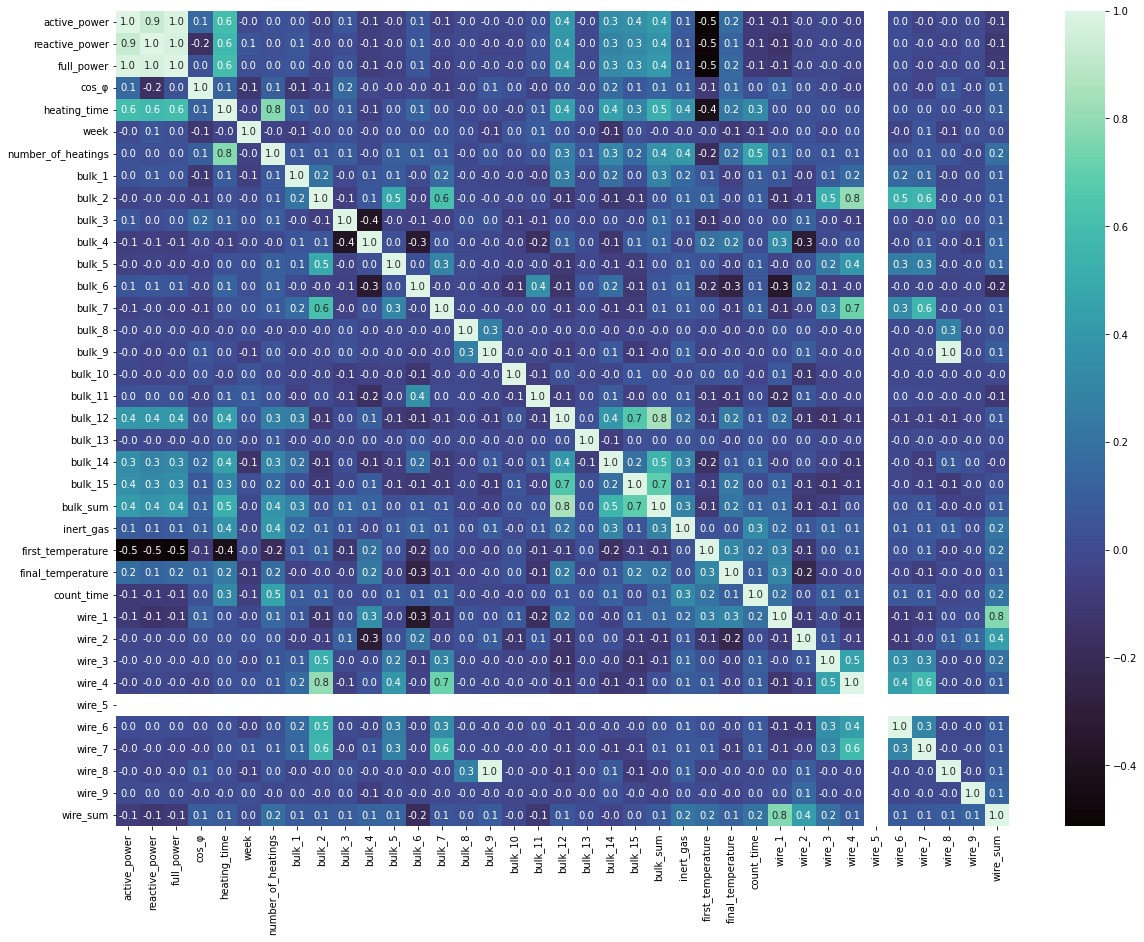

In [61]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(method='spearman'), annot=True, cmap="mako", fmt='.1f')

#### **Вывод:**
* Многие данные в сводной таблице имеют совсем разную шкалу измерений и диапазон значений, поэтому для лучшей и эффективной оптимизации алгоритмов обучения и в случае использования линейной регрессии необходимо произвести масштабирование данных. Но в данном случае линейную регрессию использовать не планируем и масштабирование делать не будем.
* Наблюдается очень сильная связь между активной, реактивной и как следствие, полной мощности.
* Поэтому удалим столбец с полной мощностью (на этапе выделения признаков) т.к. информация о ней уже присутствует в активной и реактивной мощности.
* Напротив, удалять реактивную мощность не будем т. к. она не столько зависит от активной мощности, сколько от магнитного поля, созданного прохождением переменного тока внутри печи, которое в свою очередь еще и зависит от глубины опускания электродов, химического состава и температуры расплава стали, симметричности нагрузки по фазам и других факторов.
    * Судя по распределению активной или полной мощности (неважно) и если учесть что питающий печной трансформатор при нормальном его режиме работы находится в диапазоне 20% - 125% мощности при этом технологический режим ковш-печи предусматривать рабочие короткие замыкания с кратностью тока до 2 раза от максимального из диапазона номинального тока.
    * При достаточной мощности (габаритов) питающего печного трансформатора ток и активная мощность находятся почти в линейной зависимости, но здесь на распределении активной мощности не наблюдаются никаких отделенных на 2х групп замеров мощности.
    * Плюс ко всему в соответствии с документацией к ковш-печам емкостью 100 тонн cos φ колеблется от 0.7 до 0.8, но здесь значения начиная с 0.55 и до 0.87, причем медиана находится на 0.81
    * Еще у дуговых печей есть зависимость: при увеличений тока (активной мощности) в рамках диапазона регулировки (20% - 125%) снижается cos φ, т. е. с 0.8 до 0.7    
    * Значит здесь можно предположить лишь то что печной трансформатор имеет большую мощность чем нужно, а данные о эксплуатационных КЗ просто не попали в измерения, и что диапазон регулировки мощности для установки ковш-печь больше чем на подобных (например ДСП-120), а значит и большее влияние будет оказывать реактивная мощность на общий процесс варки стали и в конечном счете на температуру.
* Наблюдается корреляция между некоторыми сыпучими, например, bulk_12, bulk_14, bulk_15.
* Наблюдается корреляция между некоторыми проволочными, например: wire_4 и wire_7
* А также между bulk_2 и (wire_4, wire_6 и wire_7)
* Корреляция между сыпучими и проволочными и между собой в основном обусловлена наличием рецептуры для изготовления конкретных видов стали, поэтому оставим как есть.
* Также высокая корреляция у созданных признаков 'wire_sum', 'bulk_sum', 'number_of_heatings' с некоторыми, удалим эти признаки.


In [62]:
list_columns = ['full_power','wire_sum', 'bulk_sum', 'number_of_heatings'] #добавим столбцы для удаления

### Обучение моделей

#### Напишем функцию разделения данных на обучающую и тестовую выборки в отношении 3:1

In [63]:
def splitting(data, list_columns):
    print('Размер поступивщих данных:', data.shape)
    list_columns = list_columns + ['final_temperature']
    features = data.drop(list_columns, axis=1)
    target = data['final_temperature']
    print('Размер features:', features.shape)
    print('Размер target:', target.shape[0])

    features_train, features_test, target_train, target_test = train_test_split(
                            features, target, test_size=0.25, random_state=190922)
    print('Размер обучающей features выборки:', features_train.shape)
    print('Размер тестовой features выборки:', features_test.shape)
    print('Размер обучающей target выборки:', target_train.shape[0])
    print('Размер тестовой target выборки:', target_test.shape[0])
    print('Удаленные столбцы из features:', list_columns)
      
    return (features_train, features_test, target_train, target_test)

#### Разделим данные на обучающую и тестовую выборки.

In [64]:
features_train, features_test, target_train, target_test = splitting(df, list_columns)

Размер поступивщих данных: (2329, 37)
Размер features: (2329, 32)
Размер target: 2329
Размер обучающей features выборки: (1746, 32)
Размер тестовой features выборки: (583, 32)
Размер обучающей target выборки: 1746
Размер тестовой target выборки: 583
Удаленные столбцы из features: ['full_power', 'wire_sum', 'bulk_sum', 'number_of_heatings', 'final_temperature']


#### Напишем функцию подбора гиперпераметров для модели методом RandomizedSearchCV с кросс-валидацией (cv=5) по обучающей выборке и фиксацией времени обучения и предсказания.

In [65]:
def search_best_parameters(model, param, features_train=features_train):
    results = None
    search = RandomizedSearchCV(
        model,
        param,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=RANDOM_STATE
    ) 
    search.fit(features_train, target_train)
    predict = search.predict(features_train)
    
    results = pd.DataFrame(search.cv_results_)
    fit_time = round(results[results['rank_test_score'] == 1]['std_fit_time'].values[0], 3)
    predict_time = round(results[results['rank_test_score'] == 1]['mean_score_time'].values[0], 3)
    best_params = results[results['rank_test_score'] == 1]['params'].values[0]
    best_score = round(results[results['rank_test_score'] == 1]['mean_test_score'].values[0], 2) * (-1)
    
    print('Время обучения:', fit_time)
    print('Время предсказания:', predict_time)
    print('МАЕ на обучающей выборке cv=5:', best_score)
    print('Лучшие гиперпараметры:', best_params )
    model_report = best_score, fit_time, predict_time
    return search.best_estimator_, model_report, search.cv_results_


### Создадим модели DecisionTreeRegressor,  RandomForestRegressor, CatBoostRegressor, LighGBMRegressor и константную модель со средним предсказанием, подберем лучшие параметры, обучим и получим предсказания с расчетом MAE и временем этих операций.

#### Модель DecisionTreeRegressor 

In [66]:
decision_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
param = {'max_depth':range (5, 15)}
best_decision_tree, best_decision_tree_report, all_results_tree = search_best_parameters(decision_tree, param)
print('Обученная модель с лучшеми гиперпараметрами', best_decision_tree)

Время обучения: 0.001
Время предсказания: 0.004
МАЕ на обучающей выборке cv=5: 7.41
Лучшие гиперпараметры: {'max_depth': 6}
Обученная модель с лучшеми гиперпараметрами DecisionTreeRegressor(max_depth=6, random_state=190922)


#### Модель RandomForestRegressor 

In [67]:
random_forest = RandomForestRegressor(random_state=RANDOM_STATE)
param = {'n_estimators':range(300, 330, 10), 'max_depth':range (16, 19)}
best_random_forest, best_random_forest_report, all_results_forest = search_best_parameters(random_forest, param)
print('Обученная модель с лучшеми гиперпараметрами', best_random_forest)

Время обучения: 0.504
Время предсказания: 0.104
МАЕ на обучающей выборке cv=5: 6.1
Лучшие гиперпараметры: {'n_estimators': 300, 'max_depth': 18}
Обученная модель с лучшеми гиперпараметрами RandomForestRegressor(max_depth=18, n_estimators=300, random_state=190922)


#### Модель CatBoostRegressor

In [68]:
catboost = CatBoostRegressor(random_state=RANDOM_STATE, silent=True)
param = {'n_estimators': [170, 175, 180], 'max_depth': range(2, 5), 'learning_rate': [0.17]}
best_catboost, best_catboost_report, all_results_cat = search_best_parameters(catboost, param)
print('Обученная модель случшеми гиперпараметрами', best_catboost)

Время обучения: 0.994
Время предсказания: 0.007
МАЕ на обучающей выборке cv=5: 5.91
Лучшие гиперпараметры: {'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.17}
Обученная модель случшеми гиперпараметрами <catboost.core.CatBoostRegressor object at 0x000001DF07BA0400>


#### Модель LightGBMRegressor

In [69]:
light_gbm = LGBMRegressor(random_state=RANDOM_STATE, categorical_feature=[5])
param = {'n_estimators': [197, 207, 217], 'max_depth': range(3, 6), 'learning_rate': [0.05]}
best_light_gbm, best_light_gbm_report, all_results_gbm = search_best_parameters(light_gbm, param)
print('Обученная модель с лучшеми гиперпараметрами', best_light_gbm)

Время обучения: 0.018
Время предсказания: 0.019
МАЕ на обучающей выборке cv=5: 6.07
Лучшие гиперпараметры: {'n_estimators': 217, 'max_depth': 3, 'learning_rate': 0.05}
Обученная модель с лучшеми гиперпараметрами LGBMRegressor(categorical_feature=[5], learning_rate=0.05, max_depth=3,
              n_estimators=217, random_state=190922)


####  Dummy модель (проверка на адекватность)

In [70]:
start_time = timeit.default_timer()
dummy = DummyRegressor(strategy="median")
dummy.fit(features_train,target_train)
predicted_dummy = dummy.predict(features_train)
elapsed_first = round(timeit.default_timer() - start_time, 3)
result = round(mean_absolute_error(target_train, predicted_dummy), 2)
dummy_score_mean = round(
    cross_val_score(
        dummy,
        features_train, 
        target_train, 
        cv=5, 
        scoring='neg_mean_absolute_error'
    ).mean(), 2
)
elapsed_second = round(timeit.default_timer() - start_time, 3)
dummy_model_report = result, elapsed_first, elapsed_second
print('Время обучения:', elapsed_first)
print('Время предсказания:', elapsed_second)
print('МАЕ на обучающей выборке:', dummy_score_mean * (-1))

Время обучения: 0.002
Время предсказания: 0.024
МАЕ на обучающей выборке: 8.07


Большее значение MAE = 8.07 (даже больше чем для DecisionTreeRegressor) для константной модели говорит об адекватности наших моделей обучения.

Соберем результаты в таблицу

In [71]:
report = (
    pd.DataFrame
    (
        [
            best_decision_tree_report, 
            best_random_forest_report, 
            best_catboost_report, 
            best_light_gbm_report, 
            dummy_model_report
        ],index = [
            'Модель DecisionTreeRegressor',
            'Модель RandomForestRegressor',
            'Модель CatBoostRegressor',
            'Модель LightGBMRegressor',
            'Dummy модель'
        ],columns = [
            'MAE', 
            'Время обучения', 
            'Время предсказания'
        ]
    )
).sort_values(by='MAE', ascending=True)

display(report)

,MAE,Время обучения,Время предсказания
Модель CatBoostRegressor,5.91,0.994,0.007
Модель LightGBMRegressor,6.07,0.018,0.019
Модель RandomForestRegressor,6.10,0.504,0.104
Модель DecisionTreeRegressor,7.41,0.001,0.004
Dummy модель,8.05,0.002,0.024


#### **Вывод:**
* Написали функцию разделения данных на обучающую и тестовую выборки в отношении 3:1
* Разделили данные на обучающую и тестовую выборки.
* Написали функцию подбора гиперпераметров для модели методом GridSearch с кросс-валидацией (cv=5) по обучающей выборке и фиксацией времени обучения и предсказания.
* Создали модели DecisionTreeRegressor,  RandomForestRegressor, CatBoostRegressor, LighGBMRegressor и константную модель со медианным предсказанием, подобрали лучшие параметры, обучили и получим предсказания на обучающей выборке с расчетом MAE с кросс-валидацией (cv=5) и временем этих операций:
* Результаты собрали в сводной таблице
* Модели RandomForestRegressor, LighGBMRegressor показали на обучающей выборке с кросс-валидацией примерно одинаковое MAE около 6, но Модель Модель CatBoostRegressor оказалась слаба по скорости обучения но на первом месте по качеству метрики МАЕ = 5.91, поэтому для финального тестирования выбираем предобученную CatBoostRegressor модель.

### Финальное тестирование предобученной CatBoostRegressor модели на тестовой выборке.

In [72]:
predict = best_catboost.predict(features_test)
result = round(mean_absolute_error(target_test, predict), 2)
print('МАЕ на тестовой выборке:', result)

МАЕ на тестовой выборке: 5.67


#### **Вывод:** МАЕ на тестовой выборке: 5.67 соответствует критерию выполнения проекта.

### Важность признаков в модели CatBoostRegressor

In [73]:
importances = pd.DataFrame(
    best_catboost.feature_importances_, 
    index=features_train.columns, 
    columns = ['Важность']
).sort_values(by='Важность', ascending=False)

Text(0.5, 1, 'Важность признаков по силе влияния на целевой признак в CatBoostRegressor')

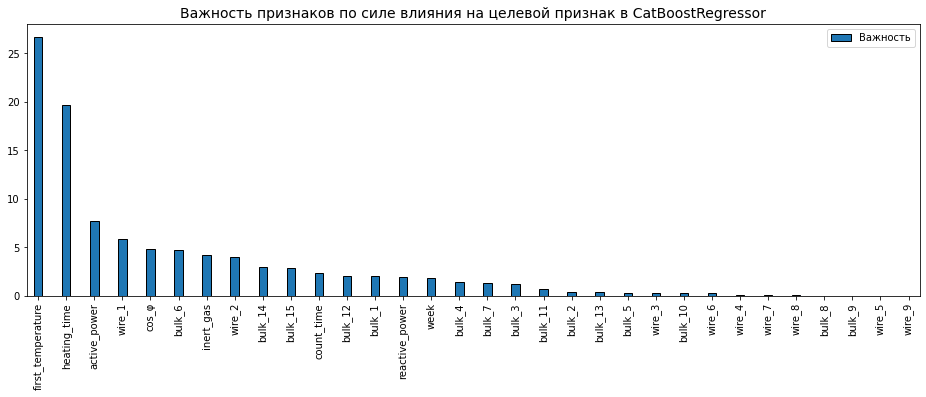

In [74]:
importances.plot(kind='bar', figsize=(16,5), ec='black', width=0.3, position=0.5)
plt.title('Важность признаков по силе влияния на целевой признак в CatBoostRegressor', size=14, y=1)

In [75]:
list_columns = importances.tail(4).index.tolist()# список 4 слабозначимых (около нулевое влияние на таргет) столбцов
print(list_columns)

['bulk_8', 'bulk_9', 'wire_5', 'wire_9']


#### **Вывод:**
* Действительно, столбцы 'bulk_8', 'bulk_9', 'wire_5', 'wire_9' имеют около нулевое влияние на целевой признак.
* Можно удалить эти столбцы  чтоб посмотреть, как измениться МАЕ.
* Наибольшее влияние оказывают столбцы:'first_temperature', 'heating_time', 'active_power', 'wire_1', 'cos_φ', 'bulk_6', 'inert_gas', 'wire_2'.

<font color='darkorange'>
    
#### **Обучение модели CatBoostRegressor на выборке без слабозначимых признаков**

Удаляем 4 слабозначимых (около нулевое влияние на таргет) признаков

In [76]:
features_train_without_weak = features_train.drop(list_columns, axis=1)
features_test_without_weak = features_test.drop(list_columns, axis=1)

Обучаем модель CatBoostRegressor

In [77]:
param = {'n_estimators': [170,190,210], 'max_depth': range(3,6), 'learning_rate': [0.1]}
(best_catboost_without_weak
 , best_catboost_without_weak_report
 , all_results_cat_without_weak) = search_best_parameters(catboost, param, features_train_without_weak)
print('Обученная модель CatBoostRegressor с лучшеми гиперпараметрами на выборке без слабозначимых признаков',
    best_catboost_without_weak)

Время обучения: 1.357
Время предсказания: 0.008
МАЕ на обучающей выборке cv=5: 5.85
Лучшие гиперпараметры: {'n_estimators': 190, 'max_depth': 5, 'learning_rate': 0.1}
Обученная модель CatBoostRegressor с лучшеми гиперпараметрами на выборке без слабозначимых признаков <catboost.core.CatBoostRegressor object at 0x000001DF0761BEE0>


<font color='darkorange'>

**Результаты CatBoostRegressor модели обученной без слабозначимых признаков на тестовой выборке.**

In [78]:
predict = best_catboost_without_weak.predict(features_test_without_weak)
result = round(mean_absolute_error(target_test, predict), 2)
print('МАЕ на тестовой выборке без слабозначимых признаков:', result)

МАЕ на тестовой выборке без слабозначимых признаков: 5.66


<font color='darkorange'>

**Вывод:**</font>
* После обучения выбранной модели CatBoostRegressor без неинформативных для модели признаков МАЕ на обучающей выборке незначительно снизилось с 5.91 до 5.85 и при этом незначительно снизилось и МАЕ с 5.67 до 5.66 на тестовой выборке.
* В связи с тем, что метрика МАЕ изменилась незначительно:
 * можно порекомендовать заказчику модель без неинформативных признаков в том случае, если параметры технологического процесса меняться не будут
 * а если же возможны какие-либо изменения в количестве или частоте применения редкоиспользуемых материалов, то стоит подумать об использовании модели обученной на всех признаках, как более универсальной.

Задача проекта выполнена.